## IIIa. Classification model builds - DA enhanced

- Use LGBM classifier to build predictive models for each augmented training dataset & evaluate on hold-out data
- Use RFE for best feature subset selection & random search for hyperparameter tuning
- Use custom PR-AUC function for all model performance evaluation on validation folds and hold-out data datasets in line with project objective
- Baseline model is built on 'Training - Balanced' dataset
- Focus evaluation of models on the threshold invariant metrics of PR/ROC-AUC. The threshold-based metrics use the probability cut-off which balances specificity and sensitivity ('ss'). Exploratory analysis shows that a cut-off based on balancing precision and recall assigns most test samples to positive class giving poor results and the 0.5 cut-off is non-sensical given the priors. Do not know how the published studies of Tsai et al (2022) and Shih et al (2023) derived their threshold cut-offs but assume it is 0.5
- Use the Scikit-learn API for LGBM classifier build as it utilises easy-to-use Scikit-learn methods & enables cross-validation with hyperparameter search which the Train API does now allow
- Check if probability scores are calibrated and if model performance (PR-AUC) is statistically different from that of other models

### Contents

1. Set up packages & drives
2. User-defined functions
3. Import & prepare data
4. Lazy predictor
5. DA enhanced models - RFE features & default hyperparameters
6. DA enhanced models - RFE features & random search hyperparameters
7. Calibration checks
8. Permutation tests

### 1. Set up packages & drives

In [ ]:
!pip install lazypredict

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from numpy import argmax,sqrt
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.metrics import make_scorer,accuracy_score,precision_score,precision_recall_curve,recall_score,f1_score,confusion_matrix,auc,roc_curve,accuracy_score,roc_auc_score,average_precision_score,log_loss,brier_score_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,train_test_split,RandomizedSearchCV,cross_val_score,permutation_test_score
import seaborn as sns
import time
import random
from scipy.stats import randint,uniform
from sklearn.feature_selection import RFE
import pickle
#from lazypredict.Supervised import LazyClassifier
from matplotlib.lines import Line2D
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.utils import check_random_state

import warnings
warnings.filterwarnings('ignore')

# Get access to Google Drive (run once per session)
drive.mount('/content/drive')

### 2. User-defined functions

In [6]:
########## Data preparation #########

def data_prep(model_name,train,test):

  ##### Get data #####

  train_df=pd.read_pickle(train)
  test_df=pd.read_pickle(test)

  ##### Standardize data #####

  # Training

  # Get all numeric features for standardization
  features=train_df.drop(['disease1','type'],axis=1)
  # Standardize numeric features
  scaler=MinMaxScaler()
  scaler.fit(features)
  features_std=scaler.transform(features)
  # Combine the standardized features with the target feature
  features_std=pd.DataFrame(features_std, columns=features.columns)
  features_std['disease1']=train_df['disease1']
  train=features_std
  # Make target feature numeric
  train['disease1']=train['disease1'].astype('int64')

  # Test

  test_features=test_df.drop('disease1',axis=1)
  # Standardize numeric features
  test_features_std=scaler.transform(test_features)
  # Combine the scaled features with the target feature
  test_features_std=pd.DataFrame(test_features_std, columns=test_features.columns)
  test_features_std['disease1']=test_df['disease1']
  test=test_features_std
  # Make target feature numeric
  test['disease1']=test['disease1'].astype('int64')

  ##### Split features and labels for model build #####

  x_train=train.drop(['disease1'],axis=1)
  y_train=train['disease1']
  x_test=test.drop(['disease1'],axis=1)
  y_test=test['disease1']

  ##### Check datasets #####

  train_samples=x_train.shape[0]
  train_labels=y_train.shape[0]
  test_samples=x_test.shape[0]
  test_labels=y_test.shape[0]
  all_samples=train_samples+test_samples
  all_labels=train_labels+test_labels
  sizing_dic={model_name:{'train_samples':train_samples,
                          'train_labels':train_labels,
                          'test_samples':test_samples,
                          'test_labels':test_labels,
                          'all_samples':all_samples,
                          'all_labels':all_labels}}

  sizing_df=pd.DataFrame.from_dict(sizing_dic,orient='index')


  return(x_train,y_train,x_test,y_test,sizing_df)

########## Custom model evaluation function ##########

def pr_auc_eval(y_true,y_pred):
    precision,recall,_=precision_recall_curve(y_true, y_pred)
    pr_auc=auc(recall,precision)
    return pr_auc

########## Calculate F1-scores (array) from precision & recall arrays #########

def f1_scores_array(precision, recall):
    # Ensure the arrays are of same length
    assert len(precision)==len(recall), "Arrays must have same length"
    # Set up scores array with default value of 0
    f1_scores=np.zeros(len(precision))
    # Calculate score for each pair of precision & recall values
    for i in range(len(precision)):
        if precision[i]==0 and recall[i]==0:
            f1_scores[i]=0
        else:
            f1_scores[i]=2*(precision[i]*recall[i])/(precision[i]+recall[i])
    return f1_scores

########## Model evaluation ###########

def model_eval(model_name, y_test, y_pred, y_class, feat_names, feat_imp, valid_score, assign_method=None):

  ##### Consider alternative methods for determining optimal threshold cut-off #####

  # Balancing recall & precision - APPEARS TO CLASSIFY ALL CLASSES AS POSITIVE CLASS - DO NOT USE

  if assign_method=='pr':
    precision0, recall0, thresholds=precision_recall_curve(y_test,y_pred)
    f1_scores=f1_scores_array(precision0, recall0)
    # Get optimal threshold
    idx=np.argmax(f1_scores)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Balancing sensitivity & specificity

  elif assign_method=='ss':
    fpr0, tpr0, thresholds=roc_curve(y_test,y_pred)
    gmeans=np.sqrt(tpr0*(1-fpr0))
    idx=np.argmax(gmeans)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Maximum probability score - default method when no argument included in function call
  else:
     y_class

  ##### Performance metrics on test data #####

  logloss=log_loss(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_class)
  recall=recall_score(y_test,y_class)
  precision=precision_score(y_test,y_class)
  tn,fp,fn,tp=confusion_matrix(y_test,y_class).ravel()
  specificity=tn/(tn+fp) if (tn+fp)!=0 else 0
  f1=f1_score(y_test,y_class)
  pr_auc=average_precision_score(y_test,y_pred)
  roc_auc=roc_auc_score(y_test,y_pred)
  fpr,tpr,_=roc_curve(y_test,y_pred)

  metrics_dic={model_name:{'tp':tp,
                           'tn':tn,
                           'fp':fp,
                           'fn':fn,
                           'logloss':logloss,
                           'accuracy':accuracy,
                           'recall':recall,
                           'precision':precision,
                           'specificity':specificity,
                           'f1_score':f1,
                           'pr_auc':pr_auc,
                           'roc_auc':roc_auc,
                           'valid_score':valid_score}}
  metrics_df=pd.DataFrame.from_dict(metrics_dic,orient='index')

  ##### Feature importance scores #####

  feat_imp_df=pd.DataFrame({'feature':feat_names,'importance':feat_imp})
  feat_imp_df=feat_imp_df.sort_values(by='importance',ascending=False)
  feat_imp_df[model_name]=round(feat_imp_df['importance'].rank(ascending=False),0)
  feat_imp_df.sort_values('feature',ascending=True,inplace=True)
  feat_imp_df.drop(columns=['importance'],axis=1,inplace=True)
  feat_imp_df=feat_imp_df.reset_index(drop=True)

  ##### PR & ROC curve data (threshold invariant) #####

  # PR curve
  precision1,recall1,thresholds=precision_recall_curve(y_test,y_pred)
  random_model=len(y_test[y_test==1])/len(y_test)
  pr_curve_dic={model_name:{'precision':precision1,
                            'recall':recall1,
                            'random_model':random_model,
                            'pr_auc':pr_auc}}
  #pr_curve_df=pd.DataFrame.from_dict(pr_curve_dic,orient='index')

  # ROC curve
  fpr,tpr,_=roc_curve(y_test,y_pred)
  roc_curve_dic={model_name:{'fpr':fpr,
                            'tpr':tpr,
                            'roc_auc':roc_auc}}
  #roc_curve_df=pd.DataFrame.from_dict(roc_curve_dic,orient='index')

  return metrics_df, feat_imp_df, pr_curve_dic, roc_curve_dic

########## RFE feature selection ##########

def feat_sel(x_train, y_train, x_test, y_test, aug_scen_name):
# This function creates a static validation datasets - it ignores the inputs of x_test & y_test
# Not using CV here due to resource restrictions

  # Split the training data into training and validation sets
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.35, random_state=42)

  # Instantiate a LightGBM classifier with default features
  clf=lgb.LGBMClassifier(verbose=-1)

  # Create a dictionary for results for each iteration of 'num_feats' (to retain)
  results={}

  # Find performance of LGBM based on different sized selections of features (1 to 36)
  for num_feats in range(1,37):

      # Instantiate the RFE on LGBM & number of features
      rfe=RFE(estimator=clf, n_features_to_select=num_feats)

      # Fit RFE to training data
      rfe.fit(x_train, y_train)

      # Get selected features
      sel_feats=x_train.columns[rfe.support_]

      # Transform train & validation datasets to include only selected features - these are arrays
      x_train_t=rfe.transform(x_train)
      x_val_t=rfe.transform(x_val)

      # Train LGBM model on training dataset with only selected features
      clf.fit(x_train_t, y_train)

      # Get probability scores & class assignments for validation data
      y_pred=clf.predict_proba(x_val_t)[:, 1]
      y_class=clf.predict(x_val_t)

      # Get performance metrics
      pr_auc=average_precision_score(y_val,y_pred)
      roc_auc=roc_auc_score(y_val,y_pred)

      # Get hyperparameters
      hypers=clf.get_params()

      # Get feature importance scores based on gain & not split
      # feature_importance.() returns scores in same order as features in training data
      feat_names=sel_feats
      feat_imp=clf.booster_.feature_importance(importance_type='gain')

      # Store metrics of each model in the results dictionary
      results[num_feats]={'num_feats':len(sel_feats),
                          'pr_auc':pr_auc,
                          'roc_auc':roc_auc,
                          'hypers':hypers,
                          'sel_feats':sel_feats,
                          'feat_names':feat_names,
                          'feat_imp':feat_imp,
                          'y_pred':y_pred,
                          'y_class':y_class}

  # Convert results dictionary into a DataFrame & reformat
  results_df=pd.DataFrame(results)
  results_df_t=results_df.T
  results_df_t['num_feats']=results_df_t['num_feats'].astype('int64')
  results_df_t[['pr_auc','roc_auc']]=results_df_t[['pr_auc','roc_auc']].astype('float64')

  # Get best model as a dictionary
  best_pr_auc_idx=results_df_t['pr_auc'].idxmax()
  best_model=results_df_t.loc[best_pr_auc_idx].to_dict()

  # Get model with all features as a dictionary
  all_feats_model=results_df_t.loc[36].to_dict()

  # Create finalised model on subsetted features, evaluate on hold-out data and replace the validation results
  best_feats=list(best_model['sel_feats'])
  clf.fit(x_train[best_feats], y_train)
  y_pred_test=clf.predict_proba(x_test[best_feats])[:, 1]
  y_class_test=clf.predict(x_test[best_feats])
  pr_auc_test=average_precision_score(y_test,y_pred_test)
  roc_auc_test=roc_auc_score(y_test,y_pred_test)
  best_model['y_pred']=y_pred_test
  best_model['y_class']=y_class_test
  best_model['pr_auc']=pr_auc_test
  best_model['roc_auc']=roc_auc_test

  return best_model, all_feats_model

########## Feature ranks heatmap ##########

def feat_heatmap(df, title, x, y, opt_flag=None):
  # Flag informs the function if the CTGAN was optimised or not

  # Sort data
  df1=df.sort_values(by=df.columns[0]).reset_index(drop=True)

  # Replace NaN with 99 (='not used by model')
  df2=df1.fillna(99)

  # Group the ranks for easier interpretation e.g. values 1, 2, 3, 4, 5 are set to 5

  def replace_values(value):

      replacement_values={ 1:5,   2:5,   3:5,   4:5,   5:5,
                          6:10,  7:10,  8:10,  9:10, 10:10,
                          11:15, 12:15, 13:15, 14:15, 15:15,
                          16:20, 17:20, 18:20, 19:20, 20:20,
                          21:25, 22:25, 23:25, 24:25, 25:25,
                          26:30, 27:30, 28:30, 29:30, 30:30,
                          31:35, 32:35, 33:35, 34:35, 35:35,
                          36:40,
                          99:99}

      return replacement_values.get(value,value)

  df3=df2.applymap(replace_values)

  # Reshape data for heatmap
  df4=pd.melt(df3, id_vars=['feature'], var_name='Model', value_name='Rank')

  # Specify order of models
  if opt_flag==1:
    custom_model_order=['_25_o','_50_o','_100_o','_250_o','_500_o','_1000_o']
  else:
    custom_model_order=['_bal','_25','_50','_100','_250','_500','_1000']

  # Convert 'Model' column to Categorical with custom order
  df4['Model']=pd.Categorical(df4['Model'], categories=custom_model_order, ordered=True)

  # Sort the dataframe & pivot
  df5=df4.sort_values(by=['feature','Model'])
  df5.rename(columns={'feature':'Feature'}, inplace=True)

  heatmap_data=df5.pivot(index='Feature', columns='Model', values='Rank')

  # Plot heat map
  colors = sns.color_palette("viridis_r", as_cmap=True)
  heatmap = sns.heatmap(heatmap_data, cmap=colors, annot=True, fmt="g", cbar=False, ax=axes[x, y])
  heatmap.set_title(title, pad=20)
  new_labels = ['Baseline','+25%','+50%','+100%','+250%','+500%','+1000%']
  heatmap.set_xticklabels(new_labels, fontsize=9)
  heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
  heatmap.set_xlabel(heatmap.get_xlabel(),fontsize=11)
  heatmap.set_ylabel(heatmap.get_ylabel(),fontsize=11)

  return

########## Build LGBM classifier using best feature subset and random search for hyperparameters ##########

def lgbm_model(eval_metric, feats, n_iter, x_train, y_train, x_test, y_test):

  # Initial grid with broader values (defaults in brackets)

  # search_grid={'num_leaves':         randint(2,50+1),       # 31
  #              'min_child_samples':  randint(15,100+1),     # 20
  #              'max_depth':          randint(1,20+1),       # -1 (no max)
  #              'learning_rate':      uniform(0.005,0.5),    # 0.1
  #              'reg_alpha':          uniform(0,0.05),       # 0.0
  #              'reg_lambda':         uniform(0,0.05),       # 0.0
  #              'n_estimators':       randint(25,150+1),     # 100
  #              'colsample_bytree':   uniform(0.3,1.0),      # 1.0
  #              'subsample':          uniform(0.5,1.0),      # 1.0
  #              'subsample_for_bin':  randint(1000,6500+1),  # 200000
  #              'subsample_freq':     randint(0,5+1),        # 0
  #              'min_split_gain':     uniform(0.001,0.05),   # 0.0
  #              'min_child_weight':   uniform(0.001,0.1)}    # 0.001

  # Narrower grid with values closer to default values (except subsample_for_bin) (defaults in brackets)

  search_grid={'num_leaves':         randint(5,60+1),       # 31
               'min_child_samples':  randint(5,60+1),       # 20
               'max_depth':          randint(1,15+1),       # -1 (no max)
               'learning_rate':      uniform(0.01,0.15),    # 0.1
               'reg_alpha':          uniform(0,0.05),       # 0.0
               'reg_lambda':         uniform(0,0.05),       # 0.0
               'n_estimators':       randint(80,120+1),     # 100
               'colsample_bytree':   uniform(0.8,1.0),      # 1.0
               'subsample':          uniform(0.7,1.0),      # 1.0
               #'subsample_for_bin':  randint(30,500+1),     # 200000
               'subsample_for_bin':  randint(1000,6500+1),  # 200000
               'subsample_freq':     randint(0,3+1),        # 0
               'min_split_gain':     uniform(0.001,0.02),   # 0.0
               'min_child_weight':   uniform(0.001,0.005)}  # 0.001

  # Instantiate the LGBM classifier
  clf=lgb.LGBMClassifier(verbose=0) # '-1' removes all output

  # Instantiate RandomisedSearchCV for optimal hyperparameter search using cross-validation
  rs=RandomizedSearchCV(estimator=clf,
                        param_distributions=search_grid,
                        scoring=eval_metric,
                        n_iter=n_iter,
                        cv=5,
                        n_jobs=-1,
                        verbose=0)  # '-1' removes all output

  # Notes:
  # 1. As the objective function is 'binary' the default evaluation function used in each run of the CV is 'binary_logloss'
  # 2. To use a different in-built evaluation function use 'scoring=' e.g. scoring='roc_auc' (quotes required)
  #    To use a custom evaluation function use 'make_scorer' which overrides in-built functions (no quote marks required around name of custom function)
  # 3. 'n_iter' is the number of (random) selections of hyperparameters from the grid per fold
  # 4. StratifiedKFold is actually used by default here
  # 5. Use all available cores with n_jobs=-1, but this may be irrelevant when run virtually on Colab

  # Perform the random search and train the model
  rs.fit(x_train[feats], y_train)

  # Get best model
  best_model=rs.best_estimator_

  # Get best (mean) validation score
  valid_score=rs.best_score_

  # Get hyperparameters of best model
  hypers=rs.best_params_

  # Get feature importance scores (based on gain & not split)
  feat_names=x_test[feats].columns.tolist()
  feat_imp=best_model.booster_.feature_importance(importance_type='gain')

  # Get evaluation data for best model
  y_pred=best_model.predict_proba(x_test[feats])[:, 1]
  y_class=best_model.predict(x_test[feats]) # Class assignment by maximum probability will change in evaluation step

  return y_pred, y_class, feat_names, feat_imp, best_model, hypers, valid_score

########## Plot reliability curves for each model's raw scores and calibrated scores ##########

def calibration_plot(pred_scores,
                     feats,
                     hypers,
                     x_train,
                     y_train,
                     x_test,
                     y_test,
                     method,
                     title,
                     pos1,
                     pos2):

  # Get reliability curve data
  prob_true, prob_pred=calibration_curve(y_test, pred_scores, n_bins=10)

  # Get calibrated pred scores - need to rebuild DA enhanced model
  clf=lgb.LGBMClassifier(**hypers, verbose=-1)
  clf.fit(x_train[feats], y_train)
  clf_cal=CalibratedClassifierCV(clf, method=method)
  clf_cal.fit(x_train[feats], y_train)
  pred_scores_cal=clf_cal.predict_proba(x_test[feats])[:, 1]

  # Create calibration reliability curve data
  prob_true_cal, prob_pred_cal=calibration_curve(y_test, pred_scores_cal, n_bins=10)

  # Calculate Brier scores
  brier_score=brier_score_loss(y_test,pred_scores)
  brier_score_cal=brier_score_loss(y_test,pred_scores_cal)

  # Plot calibration curve
  ax=axes[pos1,pos2]
  ax.plot(prob_pred, prob_true, marker='o', linestyle='-',color='magenta',label=f'Model scores (Brier={brier_score:.4f})')
  ax.plot(prob_pred_cal, prob_true_cal, marker='o', linestyle='-',color='cyan',label=f'Calibrated model scores (Brier={brier_score_cal:.4f})')
  ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')  # Perfectly calibrated line
  ax.set_xlabel('Mean predicted probability',fontsize=12)
  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.set_ylabel('Proportion of actual positives',fontsize=12)
  ax.set_title(title,fontsize=16)
  ax.legend(frameon=False,fontsize=12)
  ax.grid(True,alpha=0.3)

  return pred_scores_cal

########## Permutation test for statitsically significant models ##########

# This function code is that of Mostafa M. Amin and can be found at:
# https://mostafa-amin.com/post/permutation-significance-tests/#:~:text=A%20permutation%20test%20is%20a,the%20models%20is%20statistically%20significant.

# Function to calculate PR-AUC
def pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

def significance_test(metric_fn, y_true, y_pred_a, y_pred_b, tries=4096, random_state=41):
    assert y_true.shape[0] == y_pred_a.shape[0] == y_pred_b.shape[0]

    # Get initial test statistic
    metric_a = metric_fn(y_true, y_pred_a)
    metric_b = metric_fn(y_true, y_pred_b)
    benchmark = (metric_a - metric_b)

    if random_state is not None:
        # Fixing seed for reproducability
        np.random.seed(random_state)

    # Create the distribution of test statistics via the permutation runs
    samples = np.zeros(tries)
    for i in range(tries):
        # Create lookup to create two groups for shuffling
        msk = np.random.random(size=y_true.shape[0]) < 0.5
        y_pred_a_perm = y_pred_a.copy()
        y_pred_b_perm = y_pred_b.copy()
        y_pred_a_perm[msk] = y_pred_b[msk]
        y_pred_b_perm[msk] = y_pred_a[msk]
        samples[i]=(metric_fn(y_true, y_pred_a_perm) - metric_fn(y_true, y_pred_b_perm))

    # Calculate p-value
    pvalue = 1 - np.mean(benchmark > samples)

    return pvalue

### 3. Import & prepare data

- Imports training dataset and test datasets
- Standardizes training & transforms test
- Check sizes of datasets

In [7]:
x_train_bal_o,  y_train_bal_o,  x_test_bal_o,  y_test_bal_o,  sizing_bal_o  = data_prep('_bal',    '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_bal.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_25_o,   y_train_25_o,   x_test_25_o,   y_test_25_o,   sizing_25_o   = data_prep('_25_o',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25.pkl',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_50_o,   y_train_50_o,   x_test_50_o,   y_test_50_o,   sizing_50_o   = data_prep('_50_o',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50.pkl',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_100_o,  y_train_100_o,  x_test_100_o,  y_test_100_o,  sizing_100_o  = data_prep('_100_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_250_o,  y_train_250_o,  x_test_250_o,  y_test_250_o,  sizing_250_o  = data_prep('_250_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_500_o,  y_train_500_o,  x_test_500_o,  y_test_500_o,  sizing_500_o  = data_prep('_500_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_1000_o, y_train_1000_o, x_test_1000_o, y_test_1000_o, sizing_1000_o = data_prep('_1000_o', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

Check sizes of augmented training datasets

In [8]:
sizing_all=pd.concat([sizing_bal_o,sizing_25_o,sizing_50_o,sizing_100_o,sizing_250_o,sizing_500_o,sizing_1000_o],ignore_index=False)
sizing_all

,train_samples,train_labels,test_samples,test_labels,all_samples,all_labels
_bal,770,770,258,258,1028,1028
_25_o,950,950,258,258,1208,1208
_50_o,1140,1140,258,258,1398,1398
_100_o,1520,1520,258,258,1778,1778
_250_o,1900,1900,258,258,2158,2158
_500_o,3800,3800,258,258,4058,4058
_1000_o,7600,7600,258,258,7858,7858


### 4. Lazy predictor

- Investigate the performance of different ML algorithms on the data to get an idea of which ones to useLiterature recommends LGBM
- LGBM performs very well here
- Run on both unbalanced raw data and balanced/standairdised data

#### 4.1 Original unbalanced training data

In [ ]:
# Get training data
df_imp=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_imp.pkl')
x_train=df_imp.drop(columns=['disease1'])
y_train=df_imp['disease1']
# Get test data
df_test=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp.pkl')
x_test=df_test.drop(columns=['disease1'])
y_test=df_test['disease1']

# Note that all features are float64 format

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
# Run the lazy predicter
clf = LazyClassifier(custom_metric=pr_auc_eval, verbose=0, ignore_warnings=True)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)
models

#### 4.2. Balanced & standardised training data

In [ ]:
# Get data
x_train_bal, y_train_bal, x_test_bal, y_test_bal, sizing_bal = data_prep('_bal',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_bal.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
# Note that all features are float64 format

In [ ]:
print(x_train_bal.shape)
print(y_train_bal.shape)
print(x_test_bal.shape)
print(y_test_bal.shape)

In [ ]:
# Run the lazy predicter
clf = LazyClassifier(custom_metric=pr_auc_eval, verbose=0, ignore_warnings=True)
models, predictions = clf.fit(x_train_bal, x_test_bal, y_train_bal, y_test_bal)
models

### 5. DA enhanced models - RFE features & default hyperparameters
- Use RFE wrapper to identify the best feature subset
- Not using cross-validation in RFE wrapper due to high level of computation time required
- LGBM classifier with default hyperparameters is used as classifier for RFE as it is the classifier to be used in final model build
- Evaluation metric for each feature subset is PR-AUC in line with the project objective

#### 5.1. For each augmentation scenario build model with best feature subset & default hyperparameters

In [ ]:
_bal_o_best_model,    _bal_o_all_feats_model      =feat_sel(x_train_bal_o,   y_train_bal_o,  x_test_bal_o,  y_test_bal_o,  '_bal_o')
_25_o_best_model,     _25_o_all_feats_model       =feat_sel(x_train_25_o,    y_train_25_o,   x_test_25_o,   y_test_25_o,   '_25_o')
_50_o_best_model,     _50_o_all_feats_model       =feat_sel(x_train_50_o,    y_train_50_o,   x_test_50_o,   y_test_50_o,   '_50_o')
_100_o_best_model,    _100_o_all_feats_model      =feat_sel(x_train_100_o,   y_train_100_o,  x_test_100_o,  y_test_100_o,  '_100_o')
_250_o_best_model,    _250_o_all_feats_model      =feat_sel(x_train_250_o,   y_train_250_o,  x_test_250_o,  y_test_250_o,  '_250_o')
_500_o_best_model,    _500_o_all_feats_model      =feat_sel(x_train_500_o,   y_train_500_o,  x_test_500_o,  y_test_500_o,  '_500_o')
_1000_o_best_model,   _1000_o_all_feats_model     =feat_sel(x_train_1000_o,  y_train_1000_o, x_test_1000_o, y_test_1000_o, '_1000_o')

#### 5.2. Evaluate models

##### 5.2.1 Get performance metric data

In [ ]:
_bal_o_best_model_metrics,    _bal_o_best_model_feat_imp,   _bal_o_best_model_pr_curve_dic,   _bal_o_best_model_roc_curve_dic  = model_eval('_bal_o',  y_test_bal_o,  _bal_o_best_model['y_pred'],  _bal_o_best_model['y_class'],  _bal_o_best_model['feat_names'],  _bal_o_best_model['feat_imp'],  valid_score=None, assign_method='ss')
_25_o_best_model_metrics,     _25_o_best_model_feat_imp,    _25_o_best_model_pr_curve_dic,    _25_o_best_model_roc_curve_dic   = model_eval('_25_o',   y_test_25_o,   _25_o_best_model['y_pred'],   _25_o_best_model['y_class'],   _25_o_best_model['feat_names'],   _25_o_best_model['feat_imp'],   valid_score=None, assign_method='ss')
_50_o_best_model_metrics,     _50_o_best_model_feat_imp,    _50_o_best_model_pr_curve_dic,    _50_o_best_model_roc_curve_dic   = model_eval('_50_o',   y_test_50_o,   _50_o_best_model['y_pred'],   _50_o_best_model['y_class'],   _50_o_best_model['feat_names'],   _50_o_best_model['feat_imp'],   valid_score=None, assign_method='ss')
_100_o_best_model_metrics,    _100_o_best_model_feat_imp,   _100_o_best_model_pr_curve_dic,   _100_o_best_model_roc_curve_dic  = model_eval('_100_o',  y_test_100_o,  _100_o_best_model['y_pred'],  _100_o_best_model['y_class'],  _100_o_best_model['feat_names'],  _100_o_best_model['feat_imp'],  valid_score=None, assign_method='ss')
_250_o_best_model_metrics,    _250_o_best_model_feat_imp,   _250_o_best_model_pr_curve_dic,   _250_o_best_model_roc_curve_dic  = model_eval('_250_o',  y_test_250_o,  _250_o_best_model['y_pred'],  _250_o_best_model['y_class'],  _250_o_best_model['feat_names'],  _250_o_best_model['feat_imp'],  valid_score=None, assign_method='ss')
_500_o_best_model_metrics,    _500_o_best_model_feat_imp,   _500_o_best_model_pr_curve_dic,   _500_o_best_model_roc_curve_dic  = model_eval('_500_o',  y_test_500_o,  _500_o_best_model['y_pred'],  _500_o_best_model['y_class'],  _500_o_best_model['feat_names'],  _500_o_best_model['feat_imp'],  valid_score=None, assign_method='ss')
_1000_o_best_model_metrics,   _1000_o_best_model_feat_imp,  _1000_o_best_model_pr_curve_dic,  _1000_o_best_model_roc_curve_dic = model_eval('_1000_o', y_test_1000_o, _1000_o_best_model['y_pred'], _1000_o_best_model['y_class'], _1000_o_best_model['feat_names'], _1000_o_best_model['feat_imp'], valid_score=None, assign_method='ss')

##### 5.2.2. Create summary table of performance metrics

In [ ]:
# Need to add on number of features in each model to the table of performance metrics

best_model_opt=pd.DataFrame(columns=['model','num_feats'])
new_row = {'model' : '_bal_o', 'num_feats' : _bal_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_25_o', 'num_feats' : _25_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_50_o', 'num_feats' : _50_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_100_o', 'num_feats' : _100_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_250_o', 'num_feats' : _250_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_500_o', 'num_feats' : _500_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_1000_o', 'num_feats' : _1000_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
best_model_opt.set_index('model', inplace=True)

rfe_metrics_summary_best_model_o  = pd.concat([_bal_o_best_model_metrics, _25_o_best_model_metrics, _50_o_best_model_metrics, _100_o_best_model_metrics, _250_o_best_model_metrics, _500_o_best_model_metrics, _1000_o_best_model_metrics], axis=0).drop(columns=['valid_score'],axis=1)
rfe_metrics_summary_best_model_o1 = pd.merge(rfe_metrics_summary_best_model_o, best_model_opt, left_index=True, right_index=True)

In [ ]:
rfe_metrics_summary_best_model_o1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal_o,144,24,23,67,0.67,0.65,0.68,0.86,0.51,0.76,0.84,0.58,14
_25_o,137,29,18,74,0.70,0.64,0.65,0.88,0.62,0.75,0.86,0.61,19
_50_o,145,25,22,66,0.70,0.66,0.69,0.87,0.53,0.77,0.85,0.61,15
_100_o,128,25,22,83,0.69,0.59,0.61,0.85,0.53,0.71,0.86,0.60,33
_250_o,146,26,21,65,0.73,0.67,0.69,0.87,0.55,0.77,0.87,0.62,16
_500_o,149,25,22,62,0.70,0.67,0.71,0.87,0.53,0.78,0.87,0.64,26
_1000_o,132,27,20,79,0.78,0.62,0.63,0.87,0.57,0.73,0.88,0.63,25


##### 5.2.3. Plot PR & ROC curves

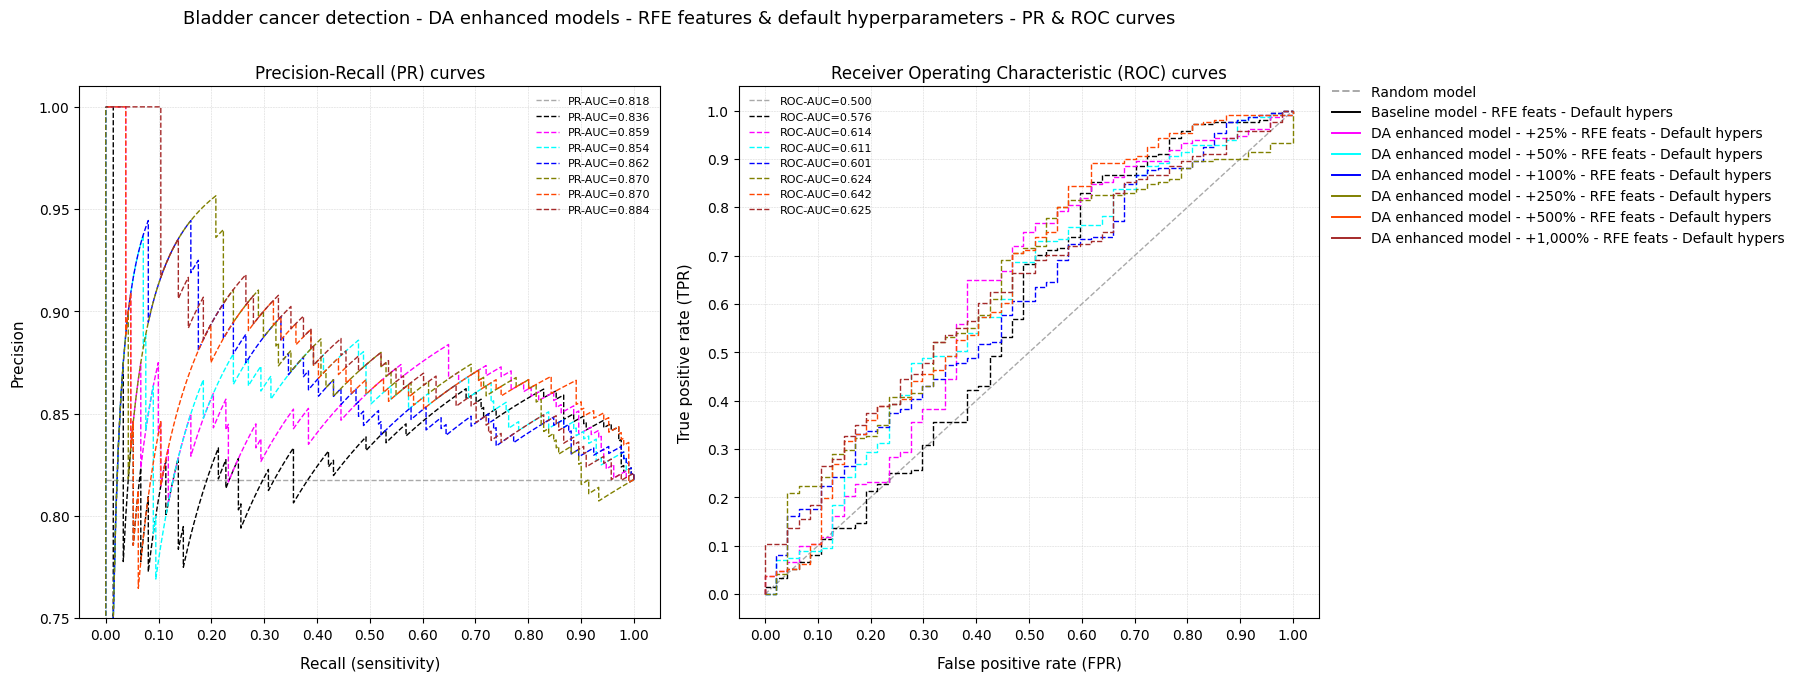

In [ ]:
########## Plot PR curves ##########

fig, axes=plt.subplots(1,2,figsize=(16,7)) # width by height

# Random model (same for all augmentation scenarios)
axes[0].plot([0, 1],
             [_bal_o_best_model_pr_curve_dic['_bal_o']['random_model'],
              _bal_o_best_model_pr_curve_dic['_bal_o']['random_model']],
             label=f"PR-AUC={_bal_o_best_model_pr_curve_dic['_bal_o']['random_model']:.3f}",
             linestyle='--',
             color='darkgray',
             lw=1)

# Bal
axes[0].plot(_bal_o_best_model_pr_curve_dic['_bal_o']['recall'],
             _bal_o_best_model_pr_curve_dic['_bal_o']['precision'],
             label=f'PR-AUC={_bal_o_best_model_pr_curve_dic["_bal_o"]["pr_auc"]:.3f}',
             linestyle='--',
             color='black',
             lw=1)

# 25
axes[0].plot(_25_o_best_model_pr_curve_dic["_25_o"]["recall"],
             _25_o_best_model_pr_curve_dic["_25_o"]["precision"],
             label=f'PR-AUC={_25_o_best_model_pr_curve_dic["_25_o"]["pr_auc"]:.3f}',
             linestyle='--',
             color="magenta",
             lw=1)

# 50
axes[0].plot(_50_o_best_model_pr_curve_dic["_50_o"]["recall"],
             _50_o_best_model_pr_curve_dic["_50_o"]["precision"],
             label=f"PR-AUC={_50_o_best_model_pr_curve_dic['_50_o']['pr_auc']:.3f}",
             linestyle='--',
             color="cyan",
             lw=1)

# 100
axes[0].plot(_100_o_best_model_pr_curve_dic["_100_o"]["recall"],
             _100_o_best_model_pr_curve_dic["_100_o"]["precision"],
             label=f"PR-AUC={_100_o_best_model_pr_curve_dic['_100_o']['pr_auc']:.3f}",
             linestyle='--',
             color="blue",
             lw=1)

# 250  - model - optimised - GA feats & default hypers
axes[0].plot(_250_o_best_model_pr_curve_dic['_250_o']['recall'],
             _250_o_best_model_pr_curve_dic['_250_o']['precision'],
             label=f"PR-AUC={_250_o_best_model_pr_curve_dic['_250_o']['pr_auc']:.3f}",
             linestyle='--',
             color="olive",
             lw=1)

# 500
axes[0].plot(_500_o_best_model_pr_curve_dic['_500_o']['recall'],
             _500_o_best_model_pr_curve_dic['_500_o']['precision'],
             label=f"PR-AUC={_500_o_best_model_pr_curve_dic['_500_o']['pr_auc']:.3f}",
             linestyle='--',
             color="orangered",
             lw=1)

# 1000
axes[0].plot(_1000_o_best_model_pr_curve_dic['_1000_o']['recall'],
             _1000_o_best_model_pr_curve_dic['_1000_o']['precision'],
             label=f"PR-AUC={_1000_o_best_model_pr_curve_dic['_1000_o']['pr_auc']:.3f}",
             linestyle='--',
             color="brown",
             lw=1)

########## ROC curve ##########

# Random model (same for all augmentation scenarios)
line1, =axes[1].plot([0, 1],
                     [0, 1],
                     label=f"ROC-AUC={0.5:.3f}",
                     linestyle='--',
                     color='darkgray',
                     lw=1)

# Bal
line2, =axes[1].plot(_bal_o_best_model_roc_curve_dic['_bal_o']['fpr'],
                     _bal_o_best_model_roc_curve_dic['_bal_o']['tpr'],
                     label=f'ROC-AUC={_bal_o_best_model_roc_curve_dic["_bal_o"]["roc_auc"]:.3f}',
                     linestyle='--',
                     color='black',
                     lw=1)

# 25
line3, = axes[1].plot(_25_o_best_model_roc_curve_dic['_25_o']['fpr'],
                      _25_o_best_model_roc_curve_dic['_25_o']['tpr'],
                      label=f'ROC-AUC={_25_o_best_model_roc_curve_dic["_25_o"]["roc_auc"]:.3f}',
                      linestyle='--',
                      color='magenta',
                      lw=1)


# 50
line4, =axes[1].plot(_50_o_best_model_roc_curve_dic["_50_o"]["fpr"],
                     _50_o_best_model_roc_curve_dic["_50_o"]["tpr"],
                     label=f"ROC-AUC={_50_o_best_model_roc_curve_dic['_50_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="cyan",
                     lw=1)

# 100
line5, =axes[1].plot(_100_o_best_model_roc_curve_dic["_100_o"]["fpr"],
                     _100_o_best_model_roc_curve_dic["_100_o"]["tpr"],
                     label=f"ROC-AUC={_100_o_best_model_roc_curve_dic['_100_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="blue",
                     lw=1)

# 250
line6, =axes[1].plot(_250_o_best_model_roc_curve_dic['_250_o']['fpr'],
                     _250_o_best_model_roc_curve_dic['_250_o']['tpr'],
                     label=f"ROC-AUC={_250_o_best_model_roc_curve_dic['_250_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="olive",
                     lw=1)

# 500
line7, =axes[1].plot(_500_o_best_model_roc_curve_dic['_500_o']['fpr'],
                     _500_o_best_model_roc_curve_dic['_500_o']['tpr'],
                     label=f"ROC-AUC={_500_o_best_model_roc_curve_dic['_500_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="orangered",
                     lw=1)

# 1000
line8, =axes[1].plot(_1000_o_best_model_roc_curve_dic['_1000_o']['fpr'],
                     _1000_o_best_model_roc_curve_dic['_1000_o']['tpr'],
                     label=f"ROC-AUC={_1000_o_best_model_roc_curve_dic['_1000_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="brown",
                     lw=1)

# Tidy up plots
fig.suptitle('Bladder cancer detection - DA enhanced models - RFE features & default hyperparameters - PR & ROC curves', fontsize=13)
fig.subplots_adjust(top=0.87, wspace=0.135)

custom_ticks = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]

axes[0].set_xticks(custom_ticks)
axes[0].set_xticklabels([f'{tick:.2f}' for tick in custom_ticks])
axes[0].set_xlabel('Recall (sensitivity)',fontsize=11,labelpad=10)
axes[0].set_ylabel('Precision',fontsize=11,labelpad=10)
axes[0].set_title('Precision-Recall (PR) curves')
axes[0].grid(True, linestyle='--', color='lightgray', linewidth=0.36)
axes[0].set_ylim(0.75,1.01)
axes[0].legend(loc='upper right', frameon=False, fontsize=8)

axes[1].set_xticks(custom_ticks)
axes[1].set_xticklabels([f'{tick:.2f}' for tick in custom_ticks])
axes[1].set_yticks(custom_ticks)
axes[1].set_xlabel('False positive rate (FPR)',fontsize=11,labelpad=10)
axes[1].set_ylabel('True positive rate (TPR)',fontsize=11,labelpad=10)
axes[1].set_title('Receiver Operating Characteristic (ROC) curves')
axes[1].grid(True, linestyle='--', color='lightgray', linewidth=0.36)
axes[1].legend(loc='upper left', frameon=False, fontsize=8)

# Add extra legend
extra_legend_elements=[Line2D([0], [0], color=line1.get_color(), linestyle=line1.get_linestyle(), lw=1.4, label='Random model'),
                       Line2D([0], [0], color=line2.get_color(), lw=1.4, label='Baseline model - RFE feats - Default hypers'),
                       Line2D([0], [0], color=line3.get_color(), lw=1.4, label='DA enhanced model - +25% - RFE feats - Default hypers'),
                       Line2D([0], [0], color=line4.get_color(), lw=1.4, label='DA enhanced model - +50% - RFE feats - Default hypers'),
                       Line2D([0], [0], color=line5.get_color(), lw=1.4, label='DA enhanced model - +100% - RFE feats - Default hypers'),
                       Line2D([0], [0], color=line6.get_color(), lw=1.4, label='DA enhanced model - +250% - RFE feats - Default hypers'),
                       Line2D([0], [0], color=line7.get_color(), lw=1.4, label='DA enhanced model - +500% - RFE feats - Default hypers'),
                       Line2D([0], [0], color=line8.get_color(), lw=1.4, label='DA enhanced model - +1,000% - RFE feats - Default hypers')]
fig.legend(handles=extra_legend_elements, bbox_to_anchor=(0.90, 0.89), loc='upper left', frameon=False)

plt.show()

##### 5.2.4. Compare (numeric) feature ranks across the models

In [ ]:
# Pull together the ranks for each augmentation scenario into one dataframe

best_model_feat_imp_all_o=_bal_o_best_model_feat_imp
for i in [_25_o_best_model_feat_imp, _50_o_best_model_feat_imp, _100_o_best_model_feat_imp, _250_o_best_model_feat_imp, _500_o_best_model_feat_imp, _1000_o_best_model_feat_imp]:
  best_model_feat_imp_all_o=pd.merge(best_model_feat_imp_all_o, i, on='feature', how='outer')

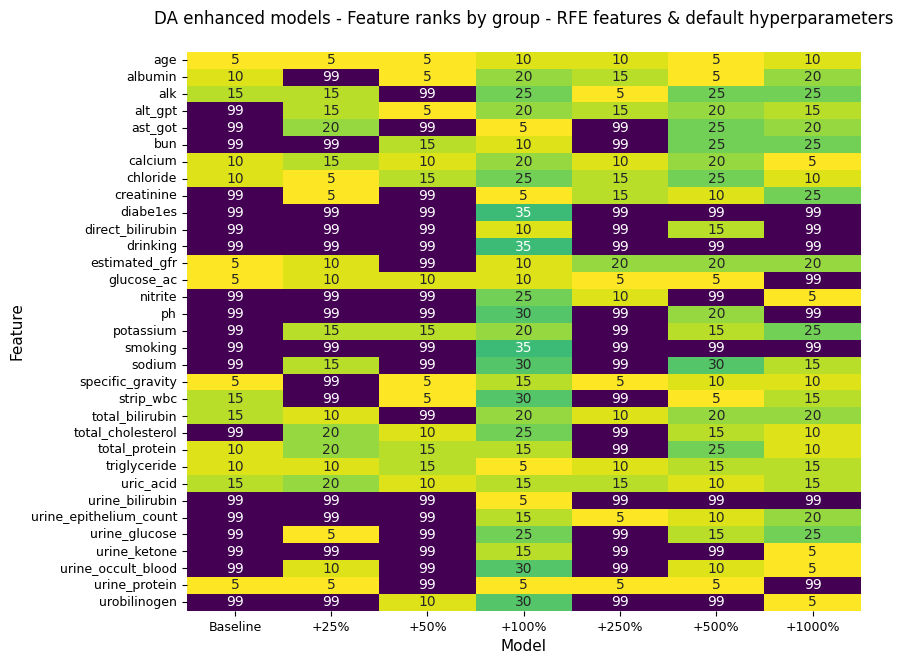

In [ ]:
# Plot heatmaps

fig,axes=plt.subplots(2,2,figsize=(20,15),gridspec_kw={'hspace': 0.2, 'wspace': 0.3}) # width by height

feat_heatmap(best_model_feat_imp_all_o, 'DA enhanced models - Feature ranks by group - RFE features & default hyperparameters', 1, 1, 1)

fig.subplots_adjust(top=0.93)

fig.delaxes(axes[0, 0])
fig.delaxes(axes[0, 1])
fig.delaxes(axes[1, 0])

plt.tight_layout()
plt.show()

#### 5.3. Save & load relevant objects

#### 5.3.1. Save

In [ ]:
# # Metric summary table

# rfe_metrics_summary_best_model_o1.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o1.pkl')

# # Model dictionaries

# # Each contains: num_feats, pr_auc, roc_auc, hypers, sel_feats, feat_names (=sel_feats), feat_imp, y_pred, y_class (based on max prob)
# # Can apply these dictionaries to model_eval() to get data ready for PR & ROC curves

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_bal_o_best_model', 'wb') as file:
#     pickle.dump(_bal_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_o_best_model', 'wb') as file:
#     pickle.dump(_25_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_o_best_model', 'wb') as file:
#     pickle.dump(_50_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_o_best_model', 'wb') as file:
#     pickle.dump(_100_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_o_best_model', 'wb') as file:
#     pickle.dump(_250_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_o_best_model', 'wb') as file:
#     pickle.dump(_500_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_o_best_model', 'wb') as file:
#     pickle.dump(_1000_o_best_model, file)

##### 5.3.2.Load

In [9]:
# Metric summary table

rfe_metrics_summary_best_model_o1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o1.pkl')

# Model dictionaries

# Each contains: num_feats, pr_auc, roc_auc, hypers, sel_feats, feat_names (=sel_feats), feat_imp, y_pred, y_class (based on max prob)
# Can apply these dictionaries to model_eval() to get data ready for PR & ROC curves

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_bal_o_best_model', 'rb') as file:
    _bal_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_o_best_model', 'rb') as file:
    _25_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_o_best_model', 'rb') as file:
    _50_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_o_best_model', 'rb') as file:
    _100_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_o_best_model', 'rb') as file:
    _250_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_o_best_model', 'rb') as file:
    _500_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_o_best_model', 'rb') as file:
    _1000_o_best_model=pickle.load(file)

### 6. DA enhanced models - RFE features & random search hyperparameters

- Tune the hyperparameters of each of the models built above on best feature subset
- Use a randomized search on a considered parameter grid with 50,000 random selections of hyperparameter combinations per model
- Using PR-AUC for evaluating best hyperparameters
- Initial grid was very broad in value ranges and performed poorly so a narrower grid based around default values is used. This will be used for all the different augmented datasets and for both search algorithms (random and GA) to enable a comparison between the two search algorithms. Did not have time to consider a two step approach of manually customising a grid per each augmentation dataset after repeated runs

#### 6.1. Get features subsets used in model builds (from RFE above)

In [ ]:
_bal_o_rfe_sel_feats=_bal_o_best_model['sel_feats'].tolist()
_25_o_rfe_sel_feats=_25_o_best_model['sel_feats'].tolist()
_50_o_rfe_sel_feats=_50_o_best_model['sel_feats'].tolist()
_100_o_rfe_sel_feats=_100_o_best_model['sel_feats'].tolist()
_250_o_rfe_sel_feats=_250_o_best_model['sel_feats'].tolist()
_500_o_rfe_sel_feats=_500_o_best_model['sel_feats'].tolist()
_1000_o_rfe_sel_feats=_1000_o_best_model['sel_feats'].tolist()

#### 6.2. Create models using beast feature subsets & optimized hyperparameters

In [ ]:
# Define the function to evaluate each random hyperparameter combination
pr_auc=make_scorer(pr_auc_eval,greater_is_better=True,needs_proba=True)

y_pred_bal_o,   y_class_bal_o,  feat_names_bal_o,   feat_imp_bal_o,   best_model_bal_o,   hypers_bal_o,   valid_score_bal_o   = lgbm_model(pr_auc,  _bal_o_rfe_sel_feats,   10000, x_train_bal_o,  y_train_bal_o,  x_test_bal_o,   y_test_bal_o)
y_pred_25_o,    y_class_25_o,   feat_names_25_o,    feat_imp_25_o,    best_model_25_o,    hypers_25_o,    valid_score_25_o    = lgbm_model(pr_auc,  _25_o_rfe_sel_feats,    10000, x_train_25_o,   y_train_25_o,   x_test_25_o,    y_test_25_o)
y_pred_50_o,    y_class_50_o,   feat_names_50_o,    feat_imp_50_o,    best_model_50_o,    hypers_50_o,    valid_score_50_o    = lgbm_model(pr_auc,  _50_o_rfe_sel_feats,    10000, x_train_50_o,   y_train_50_o,   x_test_50_o,    y_test_50_o)
y_pred_100_o,   y_class_100_o,  feat_names_100_o,   feat_imp_100_o,   best_model_100_o,   hypers_100_o,   valid_score_100_o   = lgbm_model(pr_auc,  _100_o_rfe_sel_feats,   10000, x_train_100_o,  y_train_100_o,  x_test_100_o,   y_test_100_o)
y_pred_250_o,   y_class_250_o,  feat_names_250_o,   feat_imp_250_o,   best_model_250_o,   hypers_250_o,   valid_score_250_o   = lgbm_model(pr_auc,  _250_o_rfe_sel_feats,   10000, x_train_250_o,  y_train_250_o,  x_test_250_o,   y_test_250_o)
y_pred_500_o,   y_class_500_o,  feat_names_500_o,   feat_imp_500_o,   best_model_500_o,   hypers_500_o,   valid_score_500_o   = lgbm_model(pr_auc,  _500_o_rfe_sel_feats,   10000, x_train_500_o,  y_train_500_o,  x_test_500_o,   y_test_500_o)
y_pred_1000_o,  y_class_1000_o, feat_names_1000_o,  feat_imp_1000_o,  best_model_1000_o,  hypers_1000_o,  valid_score_1000_o  = lgbm_model(pr_auc,  _1000_o_rfe_sel_feats,  10000, x_train_1000_o, y_train_1000_o, x_test_1000_o,  y_test_1000_o)

#### 6.3. Evaluate models

##### 6.3.1. Get performance data

In [ ]:
_bal_o_best_model_metrics_rs,    _bal_o_best_model_feat_imp_rs,   _bal_o_best_model_pr_curve_dic_rs,   _bal_o_best_model_roc_curve_dic_rs   = model_eval('_bal_o',  y_test_bal_o,  y_pred_bal_o,   y_class_bal_o,  feat_names_bal_o,  feat_imp_bal_o,  valid_score=valid_score_bal_o,  assign_method='ss')
_25_o_best_model_metrics_rs,     _25_o_best_model_feat_imp_rs,    _25_o_best_model_pr_curve_dic_rs,    _25_o_best_model_roc_curve_dic_rs    = model_eval('_25_o',   y_test_25_o,   y_pred_25_o,    y_class_25_o,   feat_names_25_o,   feat_imp_25_o,   valid_score=valid_score_25_o,   assign_method='ss')
_50_o_best_model_metrics_rs,     _50_o_best_model_feat_imp_rs,    _50_o_best_model_pr_curve_dic_rs,    _50_o_best_model_roc_curve_dic_rs    = model_eval('_50_o',   y_test_50_o,   y_pred_50_o,    y_class_50_o,   feat_names_50_o,   feat_imp_50_o,   valid_score=valid_score_50_o,   assign_method='ss')
_100_o_best_model_metrics_rs,    _100_o_best_model_feat_imp_rs,   _100_o_best_model_pr_curve_dic_rs,   _100_o_best_model_roc_curve_dic_rs   = model_eval('_100_o',  y_test_100_o,  y_pred_100_o,   y_class_100_o,  feat_names_100_o,  feat_imp_100_o,  valid_score=valid_score_100_o,  assign_method='ss')
_250_o_best_model_metrics_rs,    _250_o_best_model_feat_imp_rs,   _250_o_best_model_pr_curve_dic_rs,   _250_o_best_model_roc_curve_dic_rs   = model_eval('_250_o',  y_test_250_o,  y_pred_250_o,   y_class_250_o,  feat_names_250_o,  feat_imp_250_o,  valid_score=valid_score_250_o,  assign_method='ss')
_500_o_best_model_metrics_rs,    _500_o_best_model_feat_imp_rs,   _500_o_best_model_pr_curve_dic_rs,   _500_o_best_model_roc_curve_dic_rs   = model_eval('_500_o',  y_test_500_o,  y_pred_500_o,   y_class_500_o,  feat_names_500_o,  feat_imp_500_o,  valid_score=valid_score_500_o,  assign_method='ss')
_1000_o_best_model_metrics_rs,   _1000_o_best_model_feat_imp_rs,  _1000_o_best_model_pr_curve_dic_rs,  _1000_o_best_model_roc_curve_dic_rs  = model_eval('_1000_o', y_test_1000_o, y_pred_1000_o,  y_class_1000_o, feat_names_1000_o, feat_imp_1000_o, valid_score=valid_score_1000_o, assign_method='ss')

##### 6.3.2. Create summary table of performance metrics

- As per above, the threshold which balances sensitivity and specificity gives sensible results compared to the other two methods

In [ ]:
rfe_metrics_summary_best_model_o_rs  = pd.concat([_bal_o_best_model_metrics_rs, _25_o_best_model_metrics_rs, _50_o_best_model_metrics_rs, _100_o_best_model_metrics_rs, _250_o_best_model_metrics_rs, _500_o_best_model_metrics_rs, _1000_o_best_model_metrics_rs], axis=0).drop(columns=['valid_score'],axis=1)
rfe_metrics_summary_best_model_o_rs1 = pd.merge(rfe_metrics_summary_best_model_o_rs, rfe_metrics_summary_best_model_o1['num_feats'], left_index=True, right_index=True)

In [ ]:
rfe_metrics_summary_best_model_o_rs1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal_o,172,21,26,39,0.51,0.75,0.82,0.87,0.45,0.84,0.85,0.61,14
_25_o,179,19,28,32,0.50,0.77,0.85,0.86,0.40,0.86,0.86,0.62,19
_50_o,138,30,17,73,0.46,0.65,0.65,0.89,0.64,0.75,0.90,0.67,15
_100_o,98,32,15,113,0.54,0.50,0.46,0.87,0.68,0.60,0.87,0.59,33
_250_o,113,29,18,98,0.56,0.55,0.54,0.86,0.62,0.66,0.85,0.59,16
_500_o,120,31,16,91,0.54,0.59,0.57,0.88,0.66,0.69,0.87,0.64,26
_1000_o,120,30,17,91,0.72,0.58,0.57,0.88,0.64,0.69,0.89,0.63,25


In [ ]:
# Compare to models built on best feature subset & default hyperparameters
diff=rfe_metrics_summary_best_model_o_rs1-rfe_metrics_summary_best_model_o1
diff

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal_o,28,-3,3,-28,-0.17,0.10,0.13,0.01,-0.06,0.08,0.02,0.03,0
_25_o,42,-10,10,-42,-0.20,0.12,0.20,-0.02,-0.21,0.11,-0.00,0.00,0
_50_o,-7,5,-5,7,-0.24,-0.01,-0.03,0.02,0.11,-0.01,0.04,0.06,0
_100_o,-30,7,-7,30,-0.15,-0.09,-0.14,0.01,0.15,-0.10,0.01,-0.01,0
_250_o,-33,3,-3,33,-0.17,-0.12,-0.16,-0.01,0.06,-0.11,-0.02,-0.04,0
_500_o,-29,6,-6,29,-0.16,-0.09,-0.14,0.01,0.13,-0.09,0.00,-0.00,0
_1000_o,-12,3,-3,12,-0.05,-0.03,-0.06,0.01,0.06,-0.04,0.00,0.01,0


##### 6.3.3. Plot PR & ROC curves

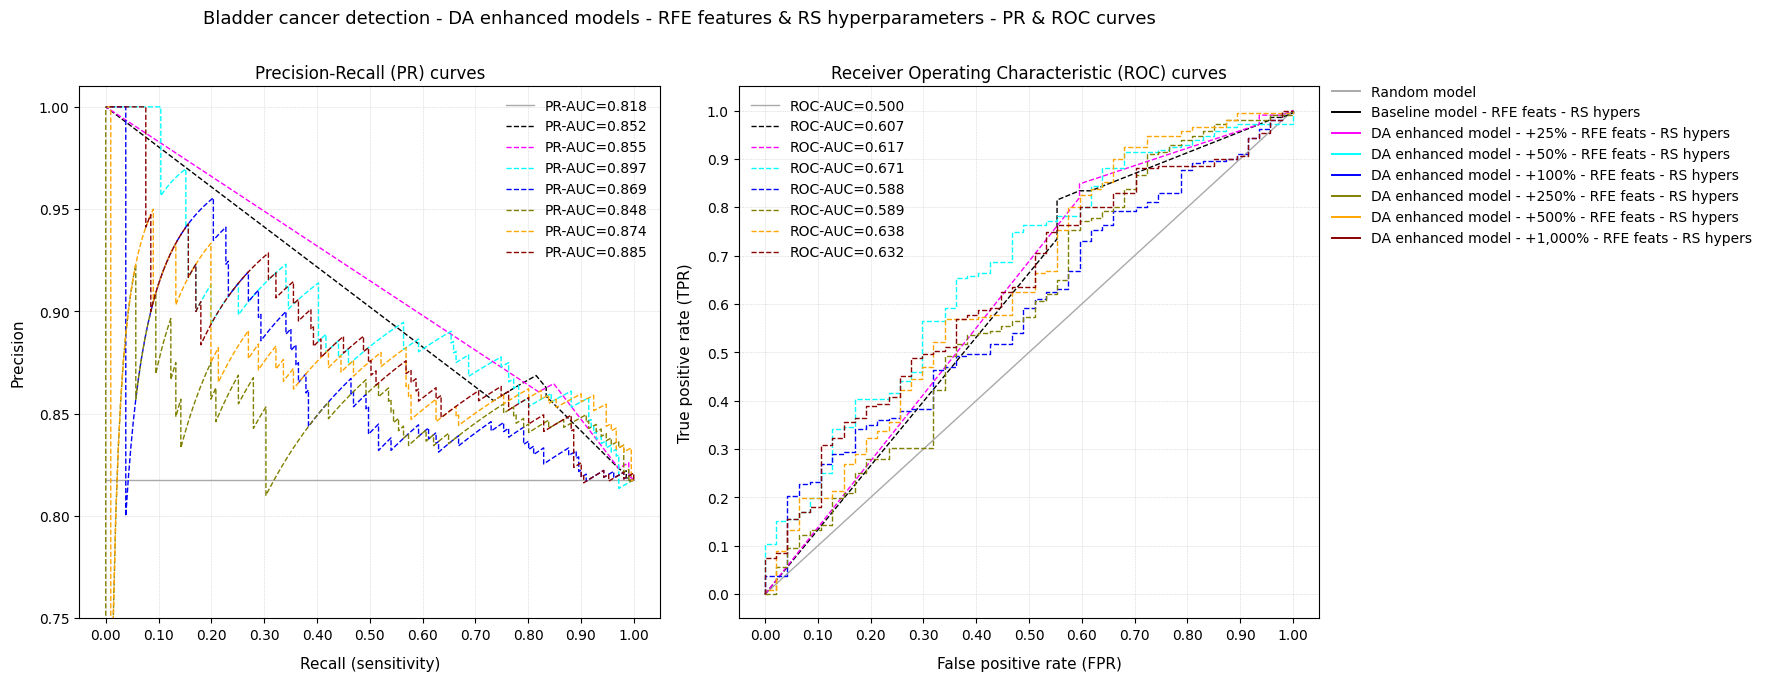

In [ ]:
########## Plot PR curves ##########

fig, axes=plt.subplots(1,2,figsize=(16,7)) # width by height

# Random model (same for all augmentation scenarios)
axes[0].plot([0, 1],
             [_bal_o_best_model_pr_curve_dic_rs['_bal_o']['random_model'],
              _bal_o_best_model_pr_curve_dic_rs['_bal_o']['random_model']],
             label=f"PR-AUC={_bal_o_best_model_pr_curve_dic_rs['_bal_o']['random_model']:.3f}",
             #linestyle='--',
             color='darkgray',
             lw=1)

# Bal
axes[0].plot(_bal_o_best_model_pr_curve_dic_rs['_bal_o']['recall'],
             _bal_o_best_model_pr_curve_dic_rs['_bal_o']['precision'],
             label=f'PR-AUC={_bal_o_best_model_pr_curve_dic_rs["_bal_o"]["pr_auc"]:.3f}',
             linestyle='--',
             color='black',
             lw=1)

# 25
axes[0].plot(_25_o_best_model_pr_curve_dic_rs["_25_o"]["recall"],
             _25_o_best_model_pr_curve_dic_rs["_25_o"]["precision"],
             label=f'PR-AUC={_25_o_best_model_pr_curve_dic_rs["_25_o"]["pr_auc"]:.3f}',
             linestyle='--',
             color="magenta",
             lw=1)

# 50
axes[0].plot(_50_o_best_model_pr_curve_dic_rs["_50_o"]["recall"],
             _50_o_best_model_pr_curve_dic_rs["_50_o"]["precision"],
             label=f"PR-AUC={_50_o_best_model_pr_curve_dic_rs['_50_o']['pr_auc']:.3f}",
             linestyle='--',
             color="cyan",
             lw=1)

# 100
axes[0].plot(_100_o_best_model_pr_curve_dic_rs["_100_o"]["recall"],
             _100_o_best_model_pr_curve_dic_rs["_100_o"]["precision"],
             label=f"PR-AUC={_100_o_best_model_pr_curve_dic_rs['_100_o']['pr_auc']:.3f}",
             linestyle='--',
             color="blue",
             lw=1)

# 250  - model - optimised - GA feats & default hypers
axes[0].plot(_250_o_best_model_pr_curve_dic_rs['_250_o']['recall'],
             _250_o_best_model_pr_curve_dic_rs['_250_o']['precision'],
             label=f"PR-AUC={_250_o_best_model_pr_curve_dic_rs['_250_o']['pr_auc']:.3f}",
             linestyle='--',
             color="olive",
             lw=1)

# 500
axes[0].plot(_500_o_best_model_pr_curve_dic_rs['_500_o']['recall'],
             _500_o_best_model_pr_curve_dic_rs['_500_o']['precision'],
             label=f"PR-AUC={_500_o_best_model_pr_curve_dic_rs['_500_o']['pr_auc']:.3f}",
             linestyle='--',
             color="orange",
             lw=1)

# 1000
axes[0].plot(_1000_o_best_model_pr_curve_dic_rs['_1000_o']['recall'],
             _1000_o_best_model_pr_curve_dic_rs['_1000_o']['precision'],
             label=f"PR-AUC={_1000_o_best_model_pr_curve_dic_rs['_1000_o']['pr_auc']:.3f}",
             linestyle='--',
             color="darkred",
             lw=1)

########## ROC curve ##########

# Random model (same for all augmentation scenarios)
line1, =axes[1].plot([0, 1],
                     [0, 1],
                     label=f"ROC-AUC={0.5:.3f}",
                     #linestyle='--',
                     color='darkgray',
                     lw=1)

# Bal
line2, =axes[1].plot(_bal_o_best_model_roc_curve_dic_rs['_bal_o']['fpr'],
                     _bal_o_best_model_roc_curve_dic_rs['_bal_o']['tpr'],
                     label=f'ROC-AUC={_bal_o_best_model_roc_curve_dic_rs["_bal_o"]["roc_auc"]:.3f}',
                     linestyle='--',
                     color='black',
                     lw=1)

# 25
line3, = axes[1].plot(_25_o_best_model_roc_curve_dic_rs['_25_o']['fpr'],
                      _25_o_best_model_roc_curve_dic_rs['_25_o']['tpr'],
                      label=f'ROC-AUC={_25_o_best_model_roc_curve_dic_rs["_25_o"]["roc_auc"]:.3f}',
                      linestyle='--',
                      color='magenta',
                      lw=1)


# 50
line4, =axes[1].plot(_50_o_best_model_roc_curve_dic_rs["_50_o"]["fpr"],
                     _50_o_best_model_roc_curve_dic_rs["_50_o"]["tpr"],
                     label=f"ROC-AUC={_50_o_best_model_roc_curve_dic_rs['_50_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="cyan",
                     lw=1)

# 100
line5, =axes[1].plot(_100_o_best_model_roc_curve_dic_rs["_100_o"]["fpr"],
                     _100_o_best_model_roc_curve_dic_rs["_100_o"]["tpr"],
                     label=f"ROC-AUC={_100_o_best_model_roc_curve_dic_rs['_100_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="blue",
                     lw=1)

# 250
line6, =axes[1].plot(_250_o_best_model_roc_curve_dic_rs['_250_o']['fpr'],
                     _250_o_best_model_roc_curve_dic_rs['_250_o']['tpr'],
                     label=f"ROC-AUC={_250_o_best_model_roc_curve_dic_rs['_250_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="olive",
                     lw=1)

# 500
line7, =axes[1].plot(_500_o_best_model_roc_curve_dic_rs['_500_o']['fpr'],
                     _500_o_best_model_roc_curve_dic_rs['_500_o']['tpr'],
                     label=f"ROC-AUC={_500_o_best_model_roc_curve_dic_rs['_500_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="orange",
                     lw=1)

# 1000
line8, =axes[1].plot(_1000_o_best_model_roc_curve_dic_rs['_1000_o']['fpr'],
                     _1000_o_best_model_roc_curve_dic_rs['_1000_o']['tpr'],
                     label=f"ROC-AUC={_1000_o_best_model_roc_curve_dic_rs['_1000_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="darkred",
                     lw=1)

# Tidy up plots
fig.suptitle('Bladder cancer detection - DA enhanced models - RFE features & RS hyperparameters - PR & ROC curves', fontsize=13)
fig.subplots_adjust(top=0.87, wspace=0.135)

custom_ticks = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]

axes[0].set_xticks(custom_ticks)
axes[0].set_xticklabels([f'{tick:.2f}' for tick in custom_ticks])
axes[0].set_xlabel('Recall (sensitivity)',fontsize=11,labelpad=10)
axes[0].set_ylabel('Precision',fontsize=11,labelpad=10)
axes[0].set_title('Precision-Recall (PR) curves')
axes[0].grid(True, linestyle='--', color='lightgray', linewidth=0.36)
axes[0].set_ylim(0.75,1.01)
axes[0].legend(loc='upper right', frameon=False, fontsize=10)

axes[1].set_xticks(custom_ticks)
axes[1].set_xticklabels([f'{tick:.2f}' for tick in custom_ticks])
axes[1].set_yticks(custom_ticks)
axes[1].set_xlabel('False positive rate (FPR)',fontsize=11,labelpad=10)
axes[1].set_ylabel('True positive rate (TPR)',fontsize=11,labelpad=10)
axes[1].set_title('Receiver Operating Characteristic (ROC) curves')
axes[1].grid(True, linestyle='--', color='lightgray', linewidth=0.36)
axes[1].legend(loc='upper left', frameon=False, fontsize=10)

# Add extra legend
extra_legend_elements=[Line2D([0], [0], color=line1.get_color(), linestyle=line1.get_linestyle(), lw=1.4, label='Random model'),
                       Line2D([0], [0], color=line2.get_color(), lw=1.4, label='Baseline model - RFE feats - RS hypers'),
                       Line2D([0], [0], color=line3.get_color(), lw=1.4, label='DA enhanced model - +25% - RFE feats - RS hypers'),
                       Line2D([0], [0], color=line4.get_color(), lw=1.4, label='DA enhanced model - +50% - RFE feats - RS hypers'),
                       Line2D([0], [0], color=line5.get_color(), lw=1.4, label='DA enhanced model - +100% - RFE feats - RS hypers'),
                       Line2D([0], [0], color=line6.get_color(), lw=1.4, label='DA enhanced model - +250% - RFE feats - RS hypers'),
                       Line2D([0], [0], color=line7.get_color(), lw=1.4, label='DA enhanced model - +500% - RFE feats - RS hypers'),
                       Line2D([0], [0], color=line8.get_color(), lw=1.4, label='DA enhanced model - +1,000% - RFE feats - RS hypers')]
fig.legend(handles=extra_legend_elements, bbox_to_anchor=(0.90, 0.89), loc='upper left', frameon=False)

plt.show()

##### 6.3.4. Compare (numeric) feature ranks across the models

In [ ]:
# Pull together the ranks for each augmentation scenario into one dataframe

best_model_feat_imp_all_o_rs=_bal_o_best_model_feat_imp_rs
for i in [_25_o_best_model_feat_imp_rs, _50_o_best_model_feat_imp_rs, _100_o_best_model_feat_imp_rs, _250_o_best_model_feat_imp_rs, _500_o_best_model_feat_imp_rs, _1000_o_best_model_feat_imp_rs]:
  best_model_feat_imp_all_o_rs=pd.merge(best_model_feat_imp_all_o_rs, i, on='feature', how='outer')

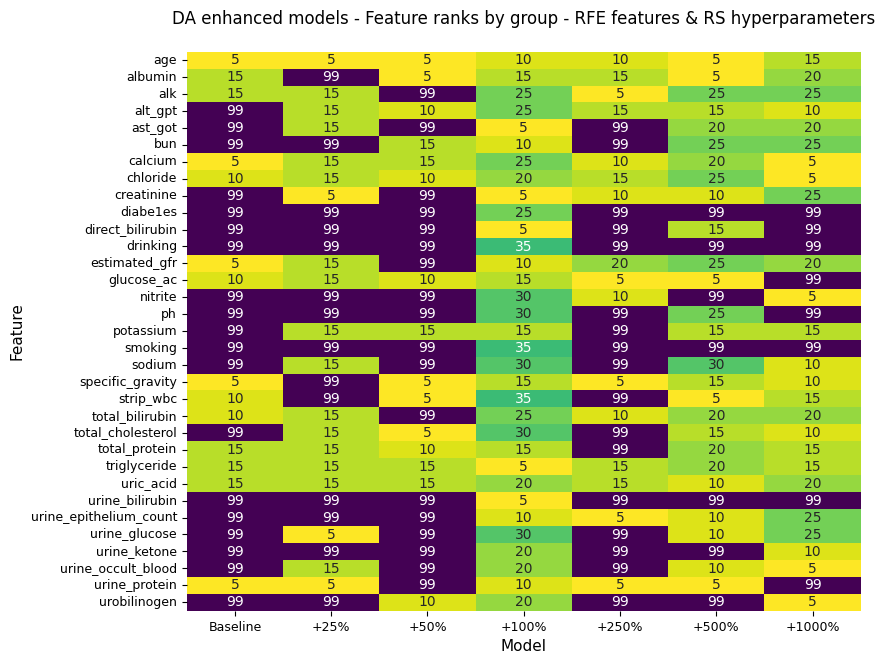

In [ ]:
# Plot heatmaps

fig,axes=plt.subplots(2,2,figsize=(20,15),gridspec_kw={'hspace': 0.2, 'wspace': 0.3}) # width by height

feat_heatmap(best_model_feat_imp_all_o_rs, 'DA enhanced models - Feature ranks by group - RFE features & RS hyperparameters', 1, 1, 1)

fig.subplots_adjust(top=0.93)

fig.delaxes(axes[0, 0])
fig.delaxes(axes[0, 1])
fig.delaxes(axes[1, 0])

plt.tight_layout()
plt.show()

#### 6.4. Save & load relevant objects

##### 6.4.1. Save

In [ ]:
# # Metric summary table

# rfe_metrics_summary_best_model_o_rs1.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o_rs1.pkl')

# # Model object & dictionaries (can apply the dictionaries to model_eval() to get data ready for PR & ROC curves)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_bal_o_rs', 'wb') as file:
#   pickle.dump(y_pred_bal_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_bal_o_rs', 'wb') as file:
#   pickle.dump(y_class_bal_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_bal_o_rs', 'wb') as file:
#   pickle.dump(feat_names_bal_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_bal_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_bal_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_bal_o_rs', 'wb') as file:
#   pickle.dump(best_model_bal_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_bal_o_rs', 'wb') as file:
#   pickle.dump(hypers_bal_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_bal_o_rs', 'wb') as file:
#   pickle.dump(valid_score_bal_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_25_o_rs', 'wb') as file:
#   pickle.dump(y_pred_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_25_o_rs', 'wb') as file:
#   pickle.dump(y_class_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_25_o_rs', 'wb') as file:
#   pickle.dump(feat_names_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_25_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_25_o_rs', 'wb') as file:
#   pickle.dump(best_model_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_25_o_rs', 'wb') as file:
#   pickle.dump(hypers_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_25_o_rs', 'wb') as file:
#   pickle.dump(valid_score_25_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_50_o_rs', 'wb') as file:
#   pickle.dump(y_pred_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_50_o_rs', 'wb') as file:
#   pickle.dump(y_class_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_50_o_rs', 'wb') as file:
#   pickle.dump(feat_names_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_50_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_50_o_rs', 'wb') as file:
#   pickle.dump(best_model_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_50_o_rs', 'wb') as file:
#   pickle.dump(hypers_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_50_o_rs', 'wb') as file:
#   pickle.dump(valid_score_50_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_100_o_rs', 'wb') as file:
#   pickle.dump(y_pred_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_100_o_rs', 'wb') as file:
#   pickle.dump(y_class_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_100_o_rs', 'wb') as file:
#   pickle.dump(feat_names_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_100_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_100_o_rs', 'wb') as file:
#   pickle.dump(best_model_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_100_o_rs', 'wb') as file:
#   pickle.dump(hypers_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_100_o_rs', 'wb') as file:
#   pickle.dump(valid_score_100_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_250_o_rs', 'wb') as file:
#   pickle.dump(y_pred_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_250_o_rs', 'wb') as file:
#   pickle.dump(y_class_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_250_o_rs', 'wb') as file:
#   pickle.dump(feat_names_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_250_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_250_o_rs', 'wb') as file:
#   pickle.dump(best_model_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_250_o_rs', 'wb') as file:
#   pickle.dump(hypers_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_250_o_rs', 'wb') as file:
#   pickle.dump(valid_score_250_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_500_o_rs', 'wb') as file:
#   pickle.dump(y_pred_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_500_o_rs', 'wb') as file:
#   pickle.dump(y_class_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_500_o_rs', 'wb') as file:
#   pickle.dump(feat_names_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_500_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_500_o_rs', 'wb') as file:
#   pickle.dump(best_model_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_500_o_rs', 'wb') as file:
#   pickle.dump(hypers_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_500_o_rs', 'wb') as file:
#   pickle.dump(valid_score_500_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_1000_o_rs', 'wb') as file:
#   pickle.dump(y_pred_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_1000_o_rs', 'wb') as file:
#   pickle.dump(y_class_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_1000_o_rs', 'wb') as file:
#   pickle.dump(feat_names_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_1000_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_1000_o_rs', 'wb') as file:
#   pickle.dump(best_model_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_1000_o_rs', 'wb') as file:
#   pickle.dump(hypers_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_1000_o_rs', 'wb') as file:
#   pickle.dump(valid_score_1000_o, file)

##### 6.4.2. Load

In [10]:
# Metric summary table

# Best subset of features - random searched hyperparameters - CTGAN optimised
rfe_metrics_summary_best_model_o_rs1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o_rs1.pkl')

# Model dictionaries

# Each contains: num_feats, pr_auc, roc_auc, hypers, sel_feats, feat_names (=sel_feats), feat_imp, y_pred, y_class (based on max prob)
# Can apply these dictionaries to model_eval() to get data ready for PR & ROC curves

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_bal_o_rs', 'rb') as file:
  y_pred_bal_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_bal_o_rs', 'rb') as file:
  y_class_bal_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_bal_o_rs', 'rb') as file:
  feat_names_bal_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_bal_o_rs', 'rb') as file:
  feat_imp_bal_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_bal_o_rs', 'rb') as file:
  best_model_bal_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_bal_o_rs', 'rb') as file:
  hypers_bal_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_bal_o_rs', 'rb') as file:
  valid_score_bal_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_25_o_rs', 'rb') as file:
  y_pred_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_25_o_rs', 'rb') as file:
  y_class_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_25_o_rs', 'rb') as file:
  feat_names_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_25_o_rs', 'rb') as file:
  feat_imp_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_25_o_rs', 'rb') as file:
  best_model_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_25_o_rs', 'rb') as file:
  hypers_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_25_o_rs', 'rb') as file:
  valid_score_25_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_50_o_rs', 'rb') as file:
  y_pred_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_50_o_rs', 'rb') as file:
  y_class_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_50_o_rs', 'rb') as file:
  feat_names_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_50_o_rs', 'rb') as file:
  feat_imp_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_50_o_rs', 'rb') as file:
  best_model_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_50_o_rs', 'rb') as file:
  hypers_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_50_o_rs', 'rb') as file:
  valid_score_50_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_100_o_rs', 'rb') as file:
  y_pred_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_100_o_rs', 'rb') as file:
  y_class_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_100_o_rs', 'rb') as file:
  feat_names_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_100_o_rs', 'rb') as file:
  feat_imp_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_100_o_rs', 'rb') as file:
  best_model_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_100_o_rs', 'rb') as file:
  hypers_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_100_o_rs', 'rb') as file:
  valid_score_100_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_250_o_rs', 'rb') as file:
  y_pred_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_250_o_rs', 'rb') as file:
  y_class_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_250_o_rs', 'rb') as file:
  feat_names_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_250_o_rs', 'rb') as file:
  feat_imp_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_250_o_rs', 'rb') as file:
  best_model_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_250_o_rs', 'rb') as file:
  hypers_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_250_o_rs', 'rb') as file:
  valid_score_250_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_500_o_rs', 'rb') as file:
  y_pred_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_500_o_rs', 'rb') as file:
  y_class_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_500_o_rs', 'rb') as file:
  feat_names_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_500_o_rs', 'rb') as file:
  feat_imp_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_500_o_rs', 'rb') as file:
  best_model_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_500_o_rs', 'rb') as file:
  hypers_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_500_o_rs', 'rb') as file:
  valid_score_500_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_1000_o_rs', 'rb') as file:
  y_pred_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_1000_o_rs', 'rb') as file:
  y_class_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_1000_o_rs', 'rb') as file:
  feat_names_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_1000_o_rs', 'rb') as file:
  feat_imp_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_1000_o_rs', 'rb') as file:
  best_model_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_1000_o_rs', 'rb') as file:
  hypers_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_1000_o_rs', 'rb') as file:
  valid_score_1000_o_rs=pickle.load(file)

### 7. Calibration checks

Calibration tells us how much we can trust a model's predictions

- When working with machine learning classifiers, it might be desirable to have the model predict probabilities of data belonging to each possible class instead of crude class labels
- Model calibration is extremely valuable to us in cases where predicted probability is of interest like bladder cancer prediction
- Calibration is the process of ensuring that the predicted probabilities reflect the true likelihood of the corresponding outcomes
- For example, if for all test samples given a probability score between 0.3 and 0.4 (probability bin 0.3-0.4 with mean probability=0.35) the proportion of actual events ('1's) are in the same range of 0.3-0.4 then the model is well calibrated for this bin
- A 'reliability plot' shows the proportion of actual '1's on y-axis for the samples in each x-axis probability score bin (which is usually represented by its mean probability score)
- If the fraction of actual '1's for each bin is close to the diagonal then the model is well calibrated. If the plot is above the diagonal for any probability scores (bin) then it means the model is under-confident and the probability scores (as per the x-axis bin) are too low. If the plot is below the diagonal for any probability scores (bin) then it means the model is over-confident and the probability scores (as per the x-axis bin) are too high
- Can also use the Brier score to check for accuracy which is simply the square of the difference between probability score and actual value (0 or 1) for each sample, then takes an average across all scores (all samples)
- If probability scores are not well calibrated can try recalibration using Platt scaling (applying a sigmoid function) and Isotonic Regression
- Platt is used for smaller datasets where reliability plot shape is sigmoid
- Isotonic Regression is for larger datasets (>1,000 samples) but doesn't require the reliability curve to be sigmoid shaped


#### 7.1. Create calibration plots

Try Platt method with Sigmoid transformation

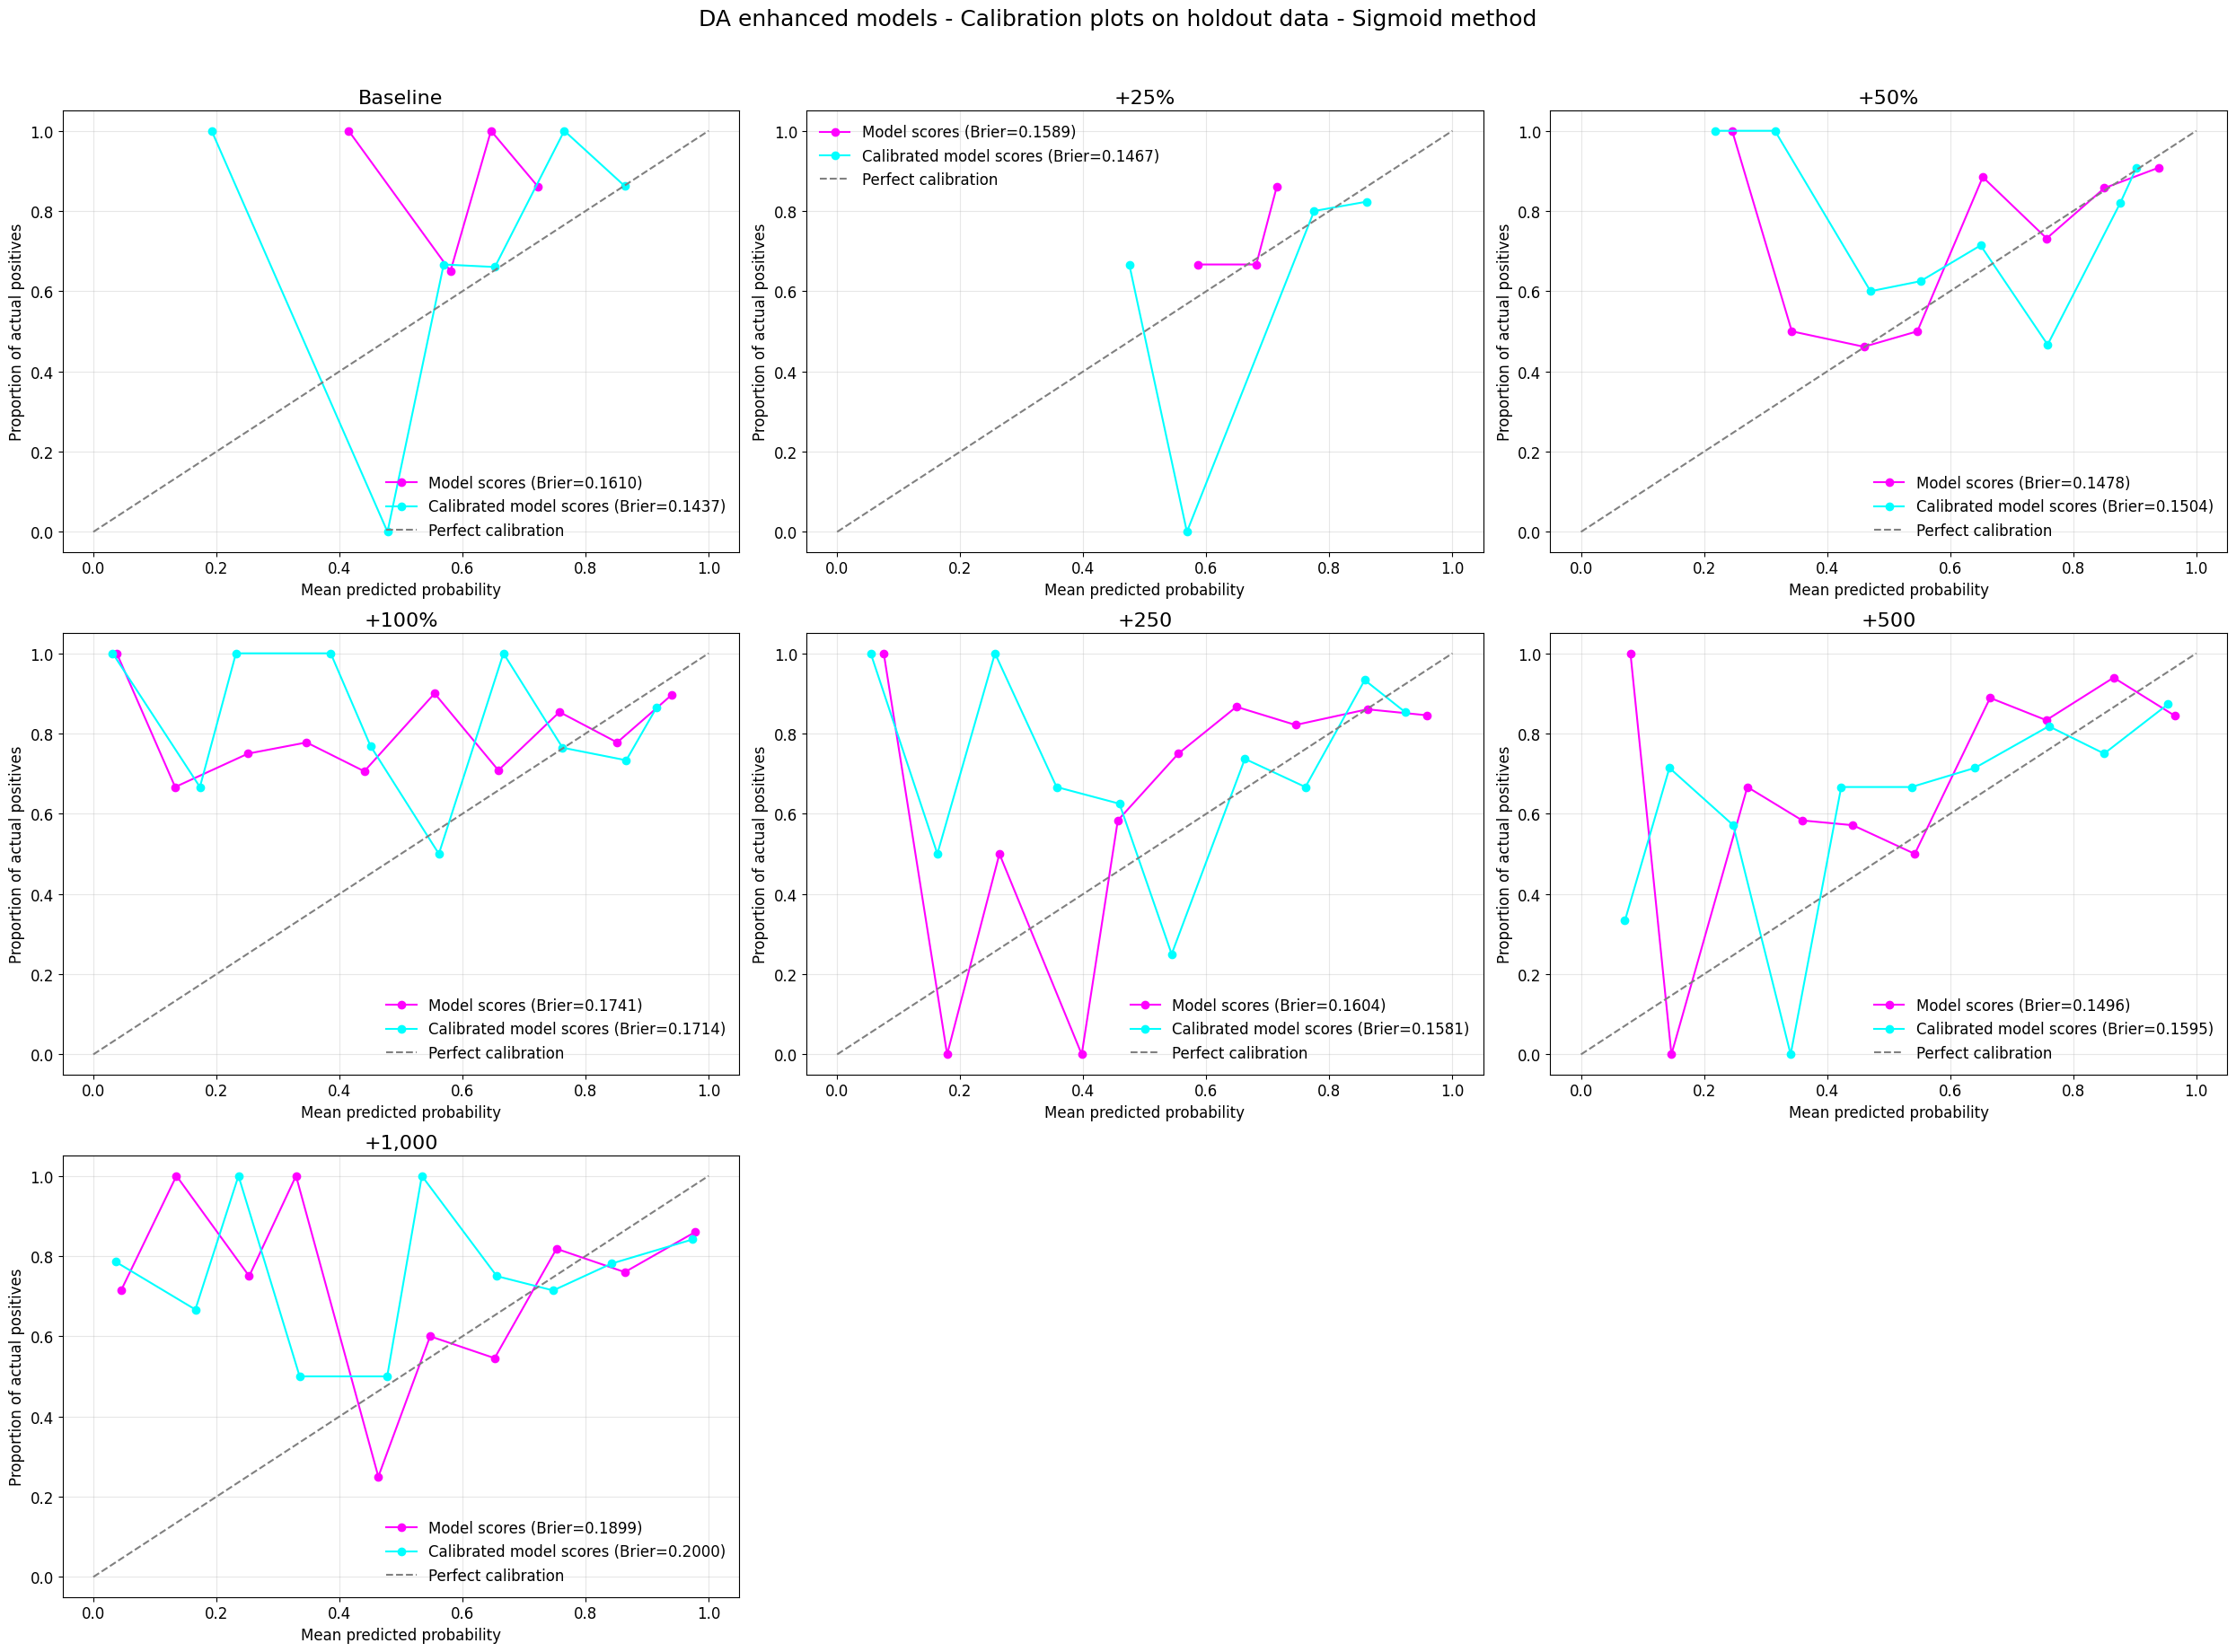

In [11]:
fig,axes = plt.subplots(3,3,figsize=(25,18))

y_pred_cal_sig_baseline = calibration_plot(y_pred_bal_o_rs,  feat_names_bal_o_rs,  hypers_bal_o_rs,  x_train_bal_o,   y_train_bal_o,   x_test_bal_o,   y_test_bal_o,  'sigmoid', 'Baseline',0,0)
y_pred_cal_sig_25       = calibration_plot(y_pred_25_o_rs,   feat_names_25_o_rs,   hypers_25_o_rs,   x_train_25_o,    y_train_25_o,    x_test_25_o,    y_test_25_o,   'sigmoid', '+25%',    0,1)
y_pred_cal_sig_50       = calibration_plot(y_pred_50_o_rs,   feat_names_50_o_rs,   hypers_50_o_rs,   x_train_50_o,    y_train_50_o,    x_test_50_o,    y_test_50_o,   'sigmoid', '+50%',    0,2)
y_pred_cal_sig_100      = calibration_plot(y_pred_100_o_rs,  feat_names_100_o_rs,  hypers_100_o_rs,  x_train_100_o,   y_train_100_o,   x_test_100_o,   y_test_100_o,  'sigmoid', '+100%',   1,0)
y_pred_cal_sig_250      = calibration_plot(y_pred_250_o_rs,  feat_names_250_o_rs,  hypers_250_o_rs,  x_train_250_o,   y_train_250_o,   x_test_250_o,   y_test_250_o,  'sigmoid', '+250',    1,1)
y_pred_cal_sig_500      = calibration_plot(y_pred_500_o_rs,  feat_names_500_o_rs,  hypers_500_o_rs,  x_train_500_o,   y_train_500_o,   x_test_500_o,   y_test_500_o,  'sigmoid', '+500',    1,2)
y_pred_cal_sig_1000     = calibration_plot(y_pred_1000_o_rs, feat_names_1000_o_rs, hypers_1000_o_rs, x_train_1000_o,  y_train_1000_o,  x_test_1000_o,  y_test_1000_o, 'sigmoid', '+1,000',  2,0)

# Delete empty panes
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

fig.suptitle('DA enhanced models - Calibration plots on holdout data - Sigmoid method', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

Try isotonic transformation

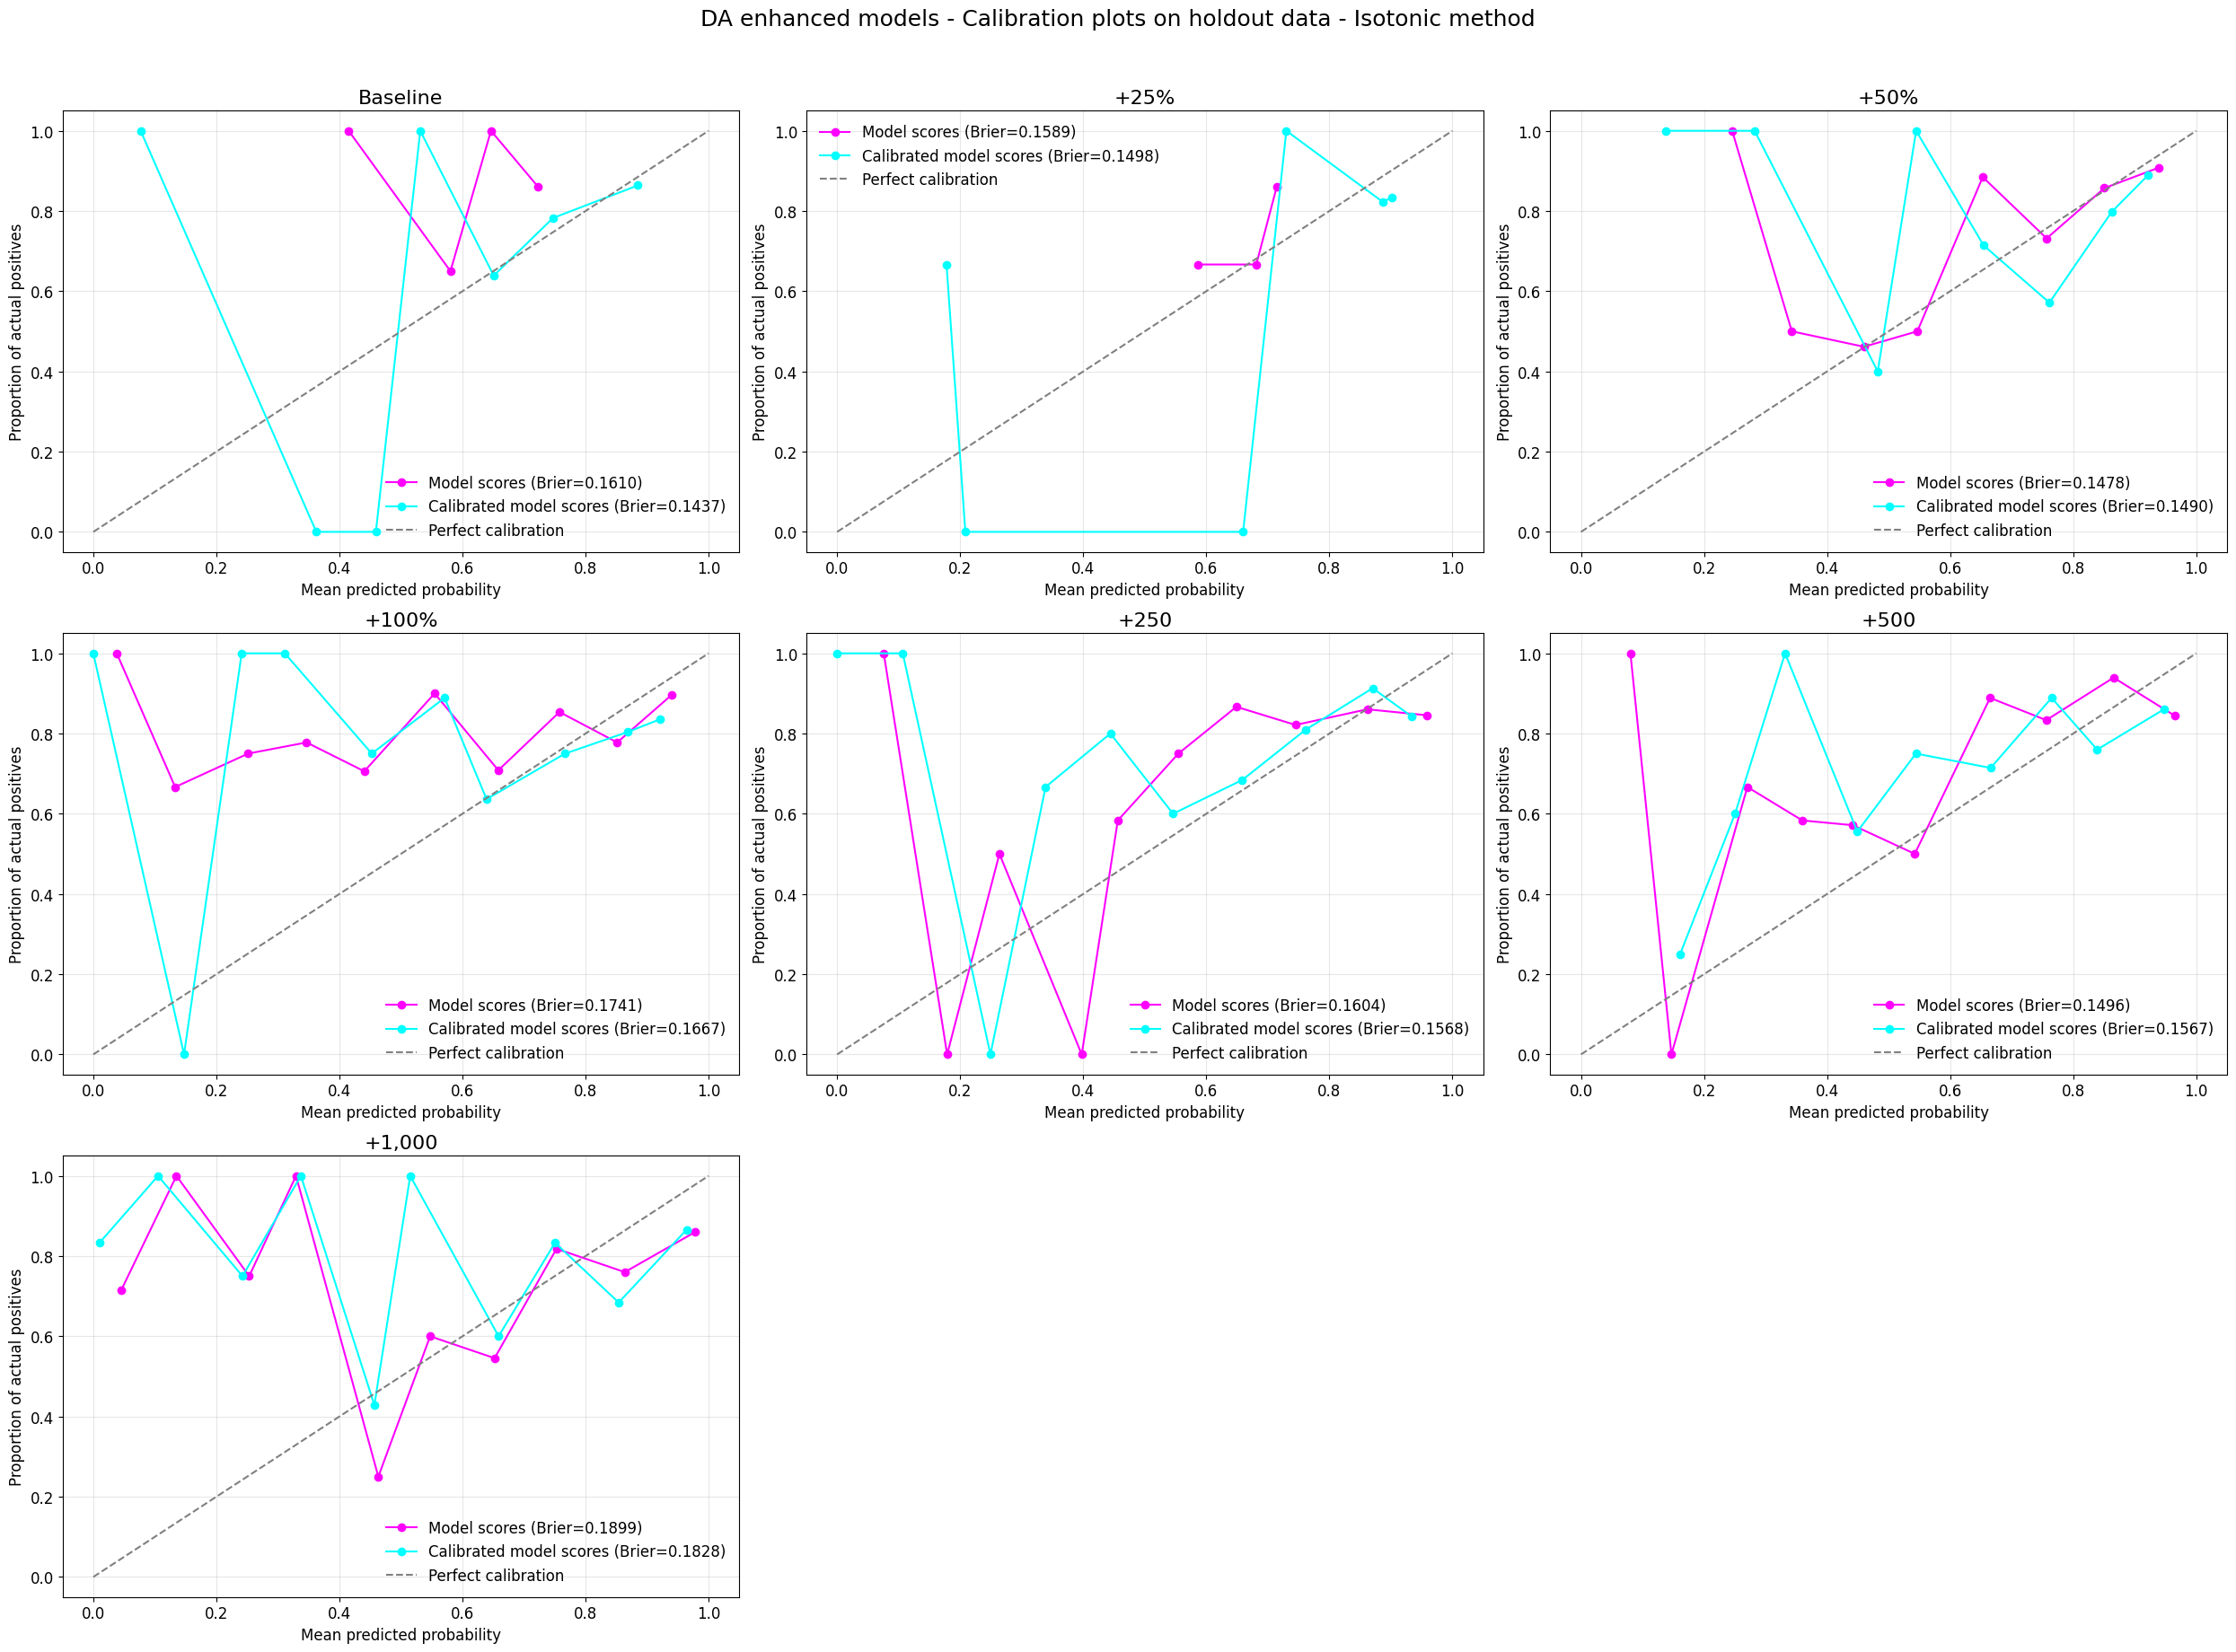

In [12]:
fig,axes = plt.subplots(3,3,figsize=(25,18))

y_pred_cal_iso_baseline = calibration_plot(y_pred_bal_o_rs,  feat_names_bal_o_rs,  hypers_bal_o_rs,  x_train_bal_o,   y_train_bal_o,   x_test_bal_o,   y_test_bal_o,  'isotonic', 'Baseline',0,0)
y_pred_cal_iso_25       = calibration_plot(y_pred_25_o_rs,   feat_names_25_o_rs,   hypers_25_o_rs,   x_train_25_o,    y_train_25_o,    x_test_25_o,    y_test_25_o,   'isotonic', '+25%',    0,1)
y_pred_cal_iso_50       = calibration_plot(y_pred_50_o_rs,   feat_names_50_o_rs,   hypers_50_o_rs,   x_train_50_o,    y_train_50_o,    x_test_50_o,    y_test_50_o,   'isotonic', '+50%',    0,2)
y_pred_cal_iso_100      = calibration_plot(y_pred_100_o_rs,  feat_names_100_o_rs,  hypers_100_o_rs,  x_train_100_o,   y_train_100_o,   x_test_100_o,   y_test_100_o,  'isotonic', '+100%',   1,0)
y_pred_cal_iso_250      = calibration_plot(y_pred_250_o_rs,  feat_names_250_o_rs,  hypers_250_o_rs,  x_train_250_o,   y_train_250_o,   x_test_250_o,   y_test_250_o,  'isotonic', '+250',    1,1)
y_pred_cal_iso_500      = calibration_plot(y_pred_500_o_rs,  feat_names_500_o_rs,  hypers_500_o_rs,  x_train_500_o,   y_train_500_o,   x_test_500_o,   y_test_500_o,  'isotonic', '+500',    1,2)
y_pred_cal_iso_1000     = calibration_plot(y_pred_1000_o_rs, feat_names_1000_o_rs, hypers_1000_o_rs, x_train_1000_o,  y_train_1000_o,  x_test_1000_o,  y_test_1000_o, 'isotonic', '+1,000',  2,0)

# Delete empty panes
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

fig.suptitle('DA enhanced models - Calibration plots on holdout data - Isotonic method', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

Asides for the baseline model, the plots and the Brier scores show little improvements which suggests that the data cannot be improved. Some of the recalibrated curves appear to be overfitting on the data. Keep the data as is except for the Baseline model with the sigmoid recalibration which showed improvement and sample size is small so isotonic transformation is not appropriate

#### 7.2. Show changes in distribution of probability scores post-calibration
Note that the gray vertical line represents the proportion of BC samples in  hold-out data

In [13]:
# Bring probability scores together
all_baseline  ={'Uncalibrated': y_pred_bal_o_rs, 'Calibrated-Sigmoid':y_pred_cal_sig_baseline,  'Calibrated-Isotonic':y_pred_cal_iso_baseline}
all_25        ={'Uncalibrated': y_pred_25_o_rs,  'Calibrated-Sigmoid':y_pred_cal_sig_25,        'Calibrated-Isotonic':y_pred_cal_iso_25}
all_50        ={'Uncalibrated': y_pred_50_o_rs,  'Calibrated-Sigmoid':y_pred_cal_sig_50,        'Calibrated-Isotonic':y_pred_cal_iso_50}
all_100       ={'Uncalibrated': y_pred_100_o_rs, 'Calibrated-Sigmoid':y_pred_cal_sig_100,       'Calibrated-Isotonic':y_pred_cal_iso_100}
all_250       ={'Uncalibrated': y_pred_250_o_rs, 'Calibrated-Sigmoid':y_pred_cal_sig_250,       'Calibrated-Isotonic':y_pred_cal_iso_250}
all_500       ={'Uncalibrated': y_pred_500_o_rs, 'Calibrated-Sigmoid':y_pred_cal_sig_500,       'Calibrated-Isotonic':y_pred_cal_iso_500}
all_1000      ={'Uncalibrated': y_pred_1000_o_rs,'Calibrated-Sigmoid':y_pred_cal_sig_1000,      'Calibrated-Isotonic':y_pred_cal_iso_1000}

all_baseline_df =pd.DataFrame(all_baseline)
all_25_df       =pd.DataFrame(all_25)
all_50_df       =pd.DataFrame(all_50)
all_100_df      =pd.DataFrame(all_100)
all_250_df      =pd.DataFrame(all_250)
all_500_df      =pd.DataFrame(all_500)
all_1000_df     =pd.DataFrame(all_1000)

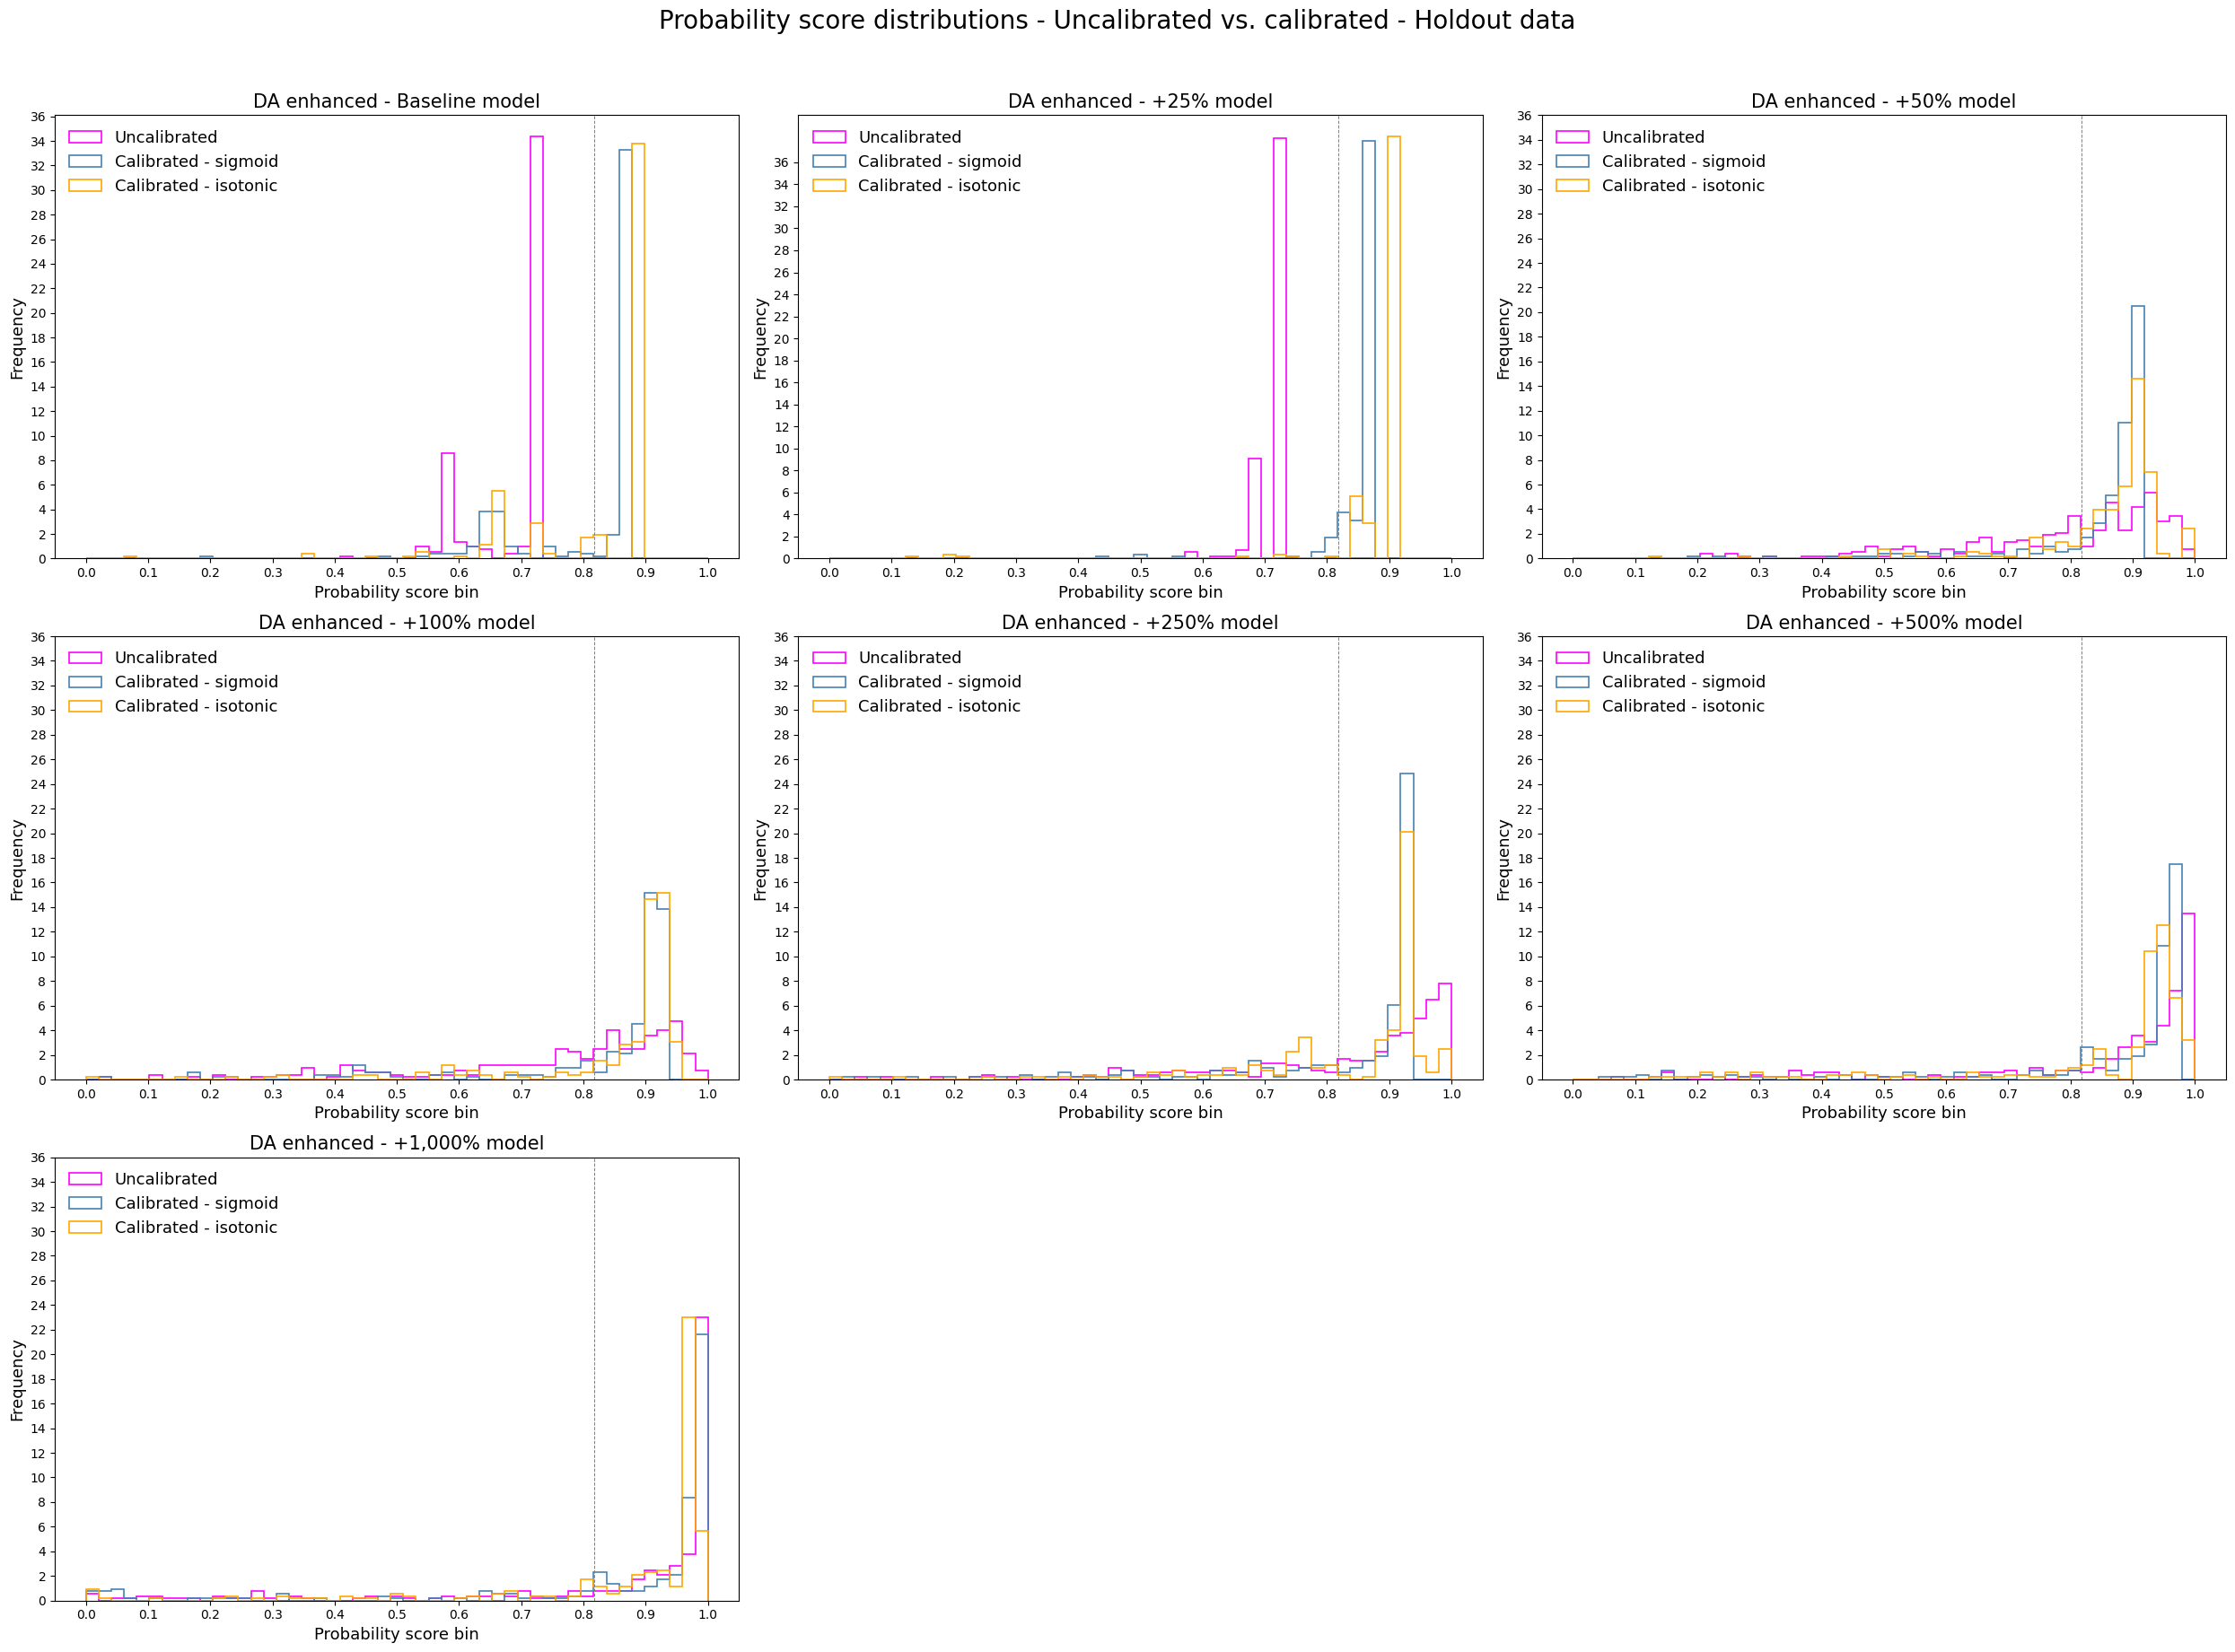

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(25, 18))

# Create the bins
bins = np.linspace(0, 1, 50)

# Plot histograms
fig.suptitle('Probability score distributions - Uncalibrated vs. calibrated - Holdout data', fontsize=20, y=1.02)

axes[0,0].hist(all_baseline_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[0,0].hist(all_baseline_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[0,0].hist(all_baseline_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[0,0].set_xticks(np.arange(0, 1.1, 0.1))
axes[0,0].set_yticks(np.arange(0, 38, 2))
axes[0,0].set_xlabel('Probability score bin',fontsize=13)
axes[0,0].set_ylabel('Frequency', fontsize=13)
axes[0,0].set_title('DA enhanced - Baseline model', fontsize=15)
axes[0,0].legend(fontsize=13,frameon=False)

axes[0,1].hist(all_25_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[0,1].hist(all_25_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[0,1].hist(all_25_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[0,1].set_xticks(np.arange(0, 1.1, 0.1))
axes[0,1].set_yticks(np.arange(0, 38, 2))
axes[0,1].set_xlabel('Probability score bin',fontsize=13)
axes[0,1].set_ylabel('Frequency', fontsize=13)
axes[0,1].set_title('DA enhanced - +25% model', fontsize=15)
axes[0,1].legend(fontsize=13,frameon=False)

axes[0,2].hist(all_50_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[0,2].hist(all_50_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[0,2].hist(all_50_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[0,2].set_xticks(np.arange(0, 1.1, 0.1))
axes[0,2].set_yticks(np.arange(0, 38, 2))
axes[0,2].set_xlabel('Probability score bin',fontsize=13)
axes[0,2].set_ylabel('Frequency', fontsize=13)
axes[0,2].set_title('DA enhanced - +50% model', fontsize=15)
axes[0,2].legend(fontsize=13,frameon=False)

axes[1,0].hist(all_100_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[1,0].hist(all_100_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[1,0].hist(all_100_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[1,0].set_xticks(np.arange(0, 1.1, 0.1))
axes[1,0].set_yticks(np.arange(0, 38, 2))
axes[1,0].set_xlabel('Probability score bin',fontsize=13)
axes[1,0].set_ylabel('Frequency', fontsize=13)
axes[1,0].set_title('DA enhanced - +100% model', fontsize=15)
axes[1,0].legend(fontsize=13,frameon=False)

axes[1,1].hist(all_250_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[1,1].hist(all_250_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[1,1].hist(all_250_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[1,1].set_xticks(np.arange(0, 1.1, 0.1))
axes[1,1].set_yticks(np.arange(0, 38, 2))
axes[1,1].set_xlabel('Probability score bin',fontsize=13)
axes[1,1].set_ylabel('Frequency', fontsize=13)
axes[1,1].set_title('DA enhanced - +250% model', fontsize=15)
axes[1,1].legend(fontsize=13,frameon=False)

axes[1,2].hist(all_500_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[1,2].hist(all_500_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[1,2].hist(all_500_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[1,2].set_xticks(np.arange(0, 1.1, 0.1))
axes[1,2].set_yticks(np.arange(0, 38, 2))
axes[1,2].set_xlabel('Probability score bin',fontsize=13)
axes[1,2].set_ylabel('Frequency', fontsize=13)
axes[1,2].set_title('DA enhanced - +500% model', fontsize=15)
axes[1,2].legend(fontsize=13,frameon=False)

axes[2,0].hist(all_1000_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[2,0].hist(all_1000_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[2,0].hist(all_1000_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[2,0].set_xticks(np.arange(0, 1.1, 0.1))
axes[2,0].set_yticks(np.arange(0, 38, 2))
axes[2,0].set_xlabel('Probability score bin',fontsize=13)
axes[2,0].set_ylabel('Frequency', fontsize=13)
axes[2,0].set_title('DA enhanced - +1,000% model', fontsize=15)
axes[2,0].legend(fontsize=13,frameon=False)

# Add line for prior probability score (holdout dataset)

axes[0,0].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[0,1].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[0,2].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[1,0].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[1,1].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[1,2].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[2,0].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
#line1=axes[2,0].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')

# Add extra legend
# extra_legend_elements=[Line2D([0], [0], color='magenta', linestyle='-', lw=1.4, label='Uncalibrated'),
#                        Line2D([0], [0], color='steelblue', linestyle='-', lw=1.4, label='Calibrated - Sigmoid'),
#                        Line2D([0], [0], color='orange', linestyle='-', lw=1.4, label='Calibrated - Isotonic'),
#                        Line2D([0], [0], color=line1.get_color(), linestyle=line1.get_linestyle(), lw=1.4, label='Prior prob of BC')]
# fig.legend(handles=extra_legend_elements, bbox_to_anchor=(0.99, 0.96), loc='upper left', frameon=False, fontsize=13)

# Delete empty panes
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

plt.tight_layout()
plt.show()

Baseline - recalculate performance metrics and save results for further analysis work

In [15]:
# Get assignments

fpr0, tpr0, thresholds=roc_curve(y_test_bal_o,y_pred_cal_sig_baseline)
gmeans=np.sqrt(tpr0*(1-fpr0))
idx=np.argmax(gmeans)
y_class=(y_pred_cal_iso_baseline>=thresholds[idx]).astype(int)

# Performance metrics on test data

logloss=log_loss(y_test_bal_o,y_pred_cal_sig_baseline)
accuracy=accuracy_score(y_test_bal_o,y_class)
recall=recall_score(y_test_bal_o,y_class)
precision=precision_score(y_test_bal_o,y_class)
tn,fp,fn,tp=confusion_matrix(y_test_bal_o,y_class).ravel()
specificity=tn/(tn+fp) if (tn+fp)!=0 else 0
f1=f1_score(y_test_bal_o,y_class)
pr_auc=average_precision_score(y_test_bal_o, y_pred_cal_sig_baseline)
roc_auc=roc_auc_score(y_test_bal_o, y_pred_cal_sig_baseline)
fpr,tpr,_=roc_curve(y_test_bal_o, y_pred_cal_sig_baseline)

metrics_dic={'_bal_o_cab':{'tp':tp,
                           'tn':tn,
                           'fp':fp,
                           'fn':fn,
                           'logloss':logloss,
                           'accuracy':accuracy,
                           'recall':recall,
                           'precision':precision,
                           'specificity':specificity,
                           'f1_score':f1,
                           'pr_auc':pr_auc,
                           'roc_auc':roc_auc,
                           'valid_score':None}}

metrics_df=pd.DataFrame.from_dict(metrics_dic,orient='index')

# PR & ROC curve data (threshold invariant)

# PR curve
precision1,recall1,thresholds=precision_recall_curve(y_test_bal_o,y_pred_cal_sig_baseline)
random_model=len(y_test_bal_o[y_test_bal_o==1])/len(y_test_bal_o)
pr_curve_dic={'_bal_o_cab':{'precision':precision1,
                          'recall':recall1,
                          'random_model':random_model,
                          'pr_auc':pr_auc}}

# ROC curve
fpr,tpr,_=roc_curve(y_test_bal_o, y_pred_cal_sig_baseline)
roc_curve_dic={'_bal_o_cab':{'fpr':fpr,
                            'tpr':tpr,
                            'roc_auc':roc_auc}}

In [16]:
metrics_dic

{'_bal_o_cab': {'tp': 153,
  'tn': 22,
  'fp': 25,
  'fn': 58,
  'logloss': 0.45846684128693393,
  'accuracy': 0.6782945736434108,
  'recall': 0.7251184834123223,
  'precision': 0.8595505617977528,
  'specificity': 0.46808510638297873,
  'f1_score': 0.7866323907455013,
  'pr_auc': 0.8601934724005773,
  'roc_auc': 0.6228698195018655,
  'valid_score': None}}

In [ ]:
# Compared to previous - performance dropped
metrics_fh_all_o

In [ ]:
# Save results

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25_o_cal', 'wb') as file:
    pickle.dump(metrics_dic, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_25_o_cal', 'wb') as file:
    pickle.dump(pr_curve_dic, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_25_o_cal', 'wb') as file:
    pickle.dump(roc_curve_dic, file)

### 8. Permutation tests

- Here the test statistic is PR-AUC. Testing if model x has PR-AUC > model y by using permutation tets approach.
- Run for each combination of models and create a null distribution by creating the test-statistic 2,500 times and determining the p-value based on the proportion of test statistics greater than the original test statistic.
- Hypotheses are:

    H0: Model x PR-AUC = Model y PR-AUC\
    H1: Model x PR-AUC > Model y PR-AUC

In [ ]:
# Baseline vs.
ba_ba       =significance_test(pr_auc, y_test_bal_o, y_pred_bal_o_rs, y_pred_bal_o_rs,    tries=2500, random_state=41)
ba_25       =significance_test(pr_auc, y_test_bal_o, y_pred_bal_o_rs, y_pred_25_o_rs,     tries=2500, random_state=41)
ba_50       =significance_test(pr_auc, y_test_bal_o, y_pred_bal_o_rs, y_pred_50_o_rs,     tries=2500, random_state=41)
ba_100      =significance_test(pr_auc, y_test_bal_o, y_pred_bal_o_rs, y_pred_100_o_rs,    tries=2500, random_state=41)
ba_250      =significance_test(pr_auc, y_test_bal_o, y_pred_bal_o_rs, y_pred_250_o_rs,    tries=2500, random_state=41)
ba_500      =significance_test(pr_auc, y_test_bal_o, y_pred_bal_o_rs, y_pred_500_o_rs,    tries=2500, random_state=41)
ba_1000     =significance_test(pr_auc, y_test_bal_o, y_pred_bal_o_rs, y_pred_1000_o_rs,   tries=2500, random_state=41)

# +25% vs.
_25_ba       =significance_test(pr_auc, y_test_bal_o, y_pred_25_o_rs, y_pred_bal_o_rs,    tries=2500, random_state=41)
_25_25       =significance_test(pr_auc, y_test_bal_o, y_pred_25_o_rs, y_pred_25_o_rs,     tries=2500, random_state=41)
_25_50       =significance_test(pr_auc, y_test_bal_o, y_pred_25_o_rs, y_pred_50_o_rs,     tries=2500, random_state=41)
_25_100      =significance_test(pr_auc, y_test_bal_o, y_pred_25_o_rs, y_pred_100_o_rs,    tries=2500, random_state=41)
_25_250      =significance_test(pr_auc, y_test_bal_o, y_pred_25_o_rs, y_pred_250_o_rs,    tries=2500, random_state=41)
_25_500      =significance_test(pr_auc, y_test_bal_o, y_pred_25_o_rs, y_pred_500_o_rs,    tries=2500, random_state=41)
_25_1000     =significance_test(pr_auc, y_test_bal_o, y_pred_25_o_rs, y_pred_1000_o_rs,   tries=2500, random_state=41)

# +50% vs.
_50_ba       =significance_test(pr_auc, y_test_bal_o, y_pred_50_o_rs, y_pred_bal_o_rs,    tries=2500, random_state=41)
_50_25       =significance_test(pr_auc, y_test_bal_o, y_pred_50_o_rs, y_pred_25_o_rs,     tries=2500, random_state=41)
_50_50       =significance_test(pr_auc, y_test_bal_o, y_pred_50_o_rs, y_pred_50_o_rs,     tries=2500, random_state=41)
_50_100      =significance_test(pr_auc, y_test_bal_o, y_pred_50_o_rs, y_pred_100_o_rs,    tries=2500, random_state=41)
_50_250      =significance_test(pr_auc, y_test_bal_o, y_pred_50_o_rs, y_pred_250_o_rs,    tries=2500, random_state=41)
_50_500      =significance_test(pr_auc, y_test_bal_o, y_pred_50_o_rs, y_pred_500_o_rs,    tries=2500, random_state=41)
_50_1000     =significance_test(pr_auc, y_test_bal_o, y_pred_50_o_rs, y_pred_1000_o_rs,   tries=2500, random_state=41)

# +100% vs.
_100_ba      =significance_test(pr_auc, y_test_bal_o, y_pred_100_o_rs, y_pred_bal_o_rs,   tries=2500, random_state=41)
_100_25      =significance_test(pr_auc, y_test_bal_o, y_pred_100_o_rs, y_pred_25_o_rs,    tries=2500, random_state=41)
_100_50      =significance_test(pr_auc, y_test_bal_o, y_pred_100_o_rs, y_pred_50_o_rs,    tries=2500, random_state=41)
_100_100     =significance_test(pr_auc, y_test_bal_o, y_pred_100_o_rs, y_pred_100_o_rs,   tries=2500, random_state=41)
_100_250     =significance_test(pr_auc, y_test_bal_o, y_pred_100_o_rs, y_pred_250_o_rs,   tries=2500, random_state=41)
_100_500     =significance_test(pr_auc, y_test_bal_o, y_pred_100_o_rs, y_pred_500_o_rs,   tries=2500, random_state=41)
_100_1000    =significance_test(pr_auc, y_test_bal_o, y_pred_100_o_rs, y_pred_1000_o_rs,  tries=2500, random_state=41)

# +250% vs.
_250_ba      =significance_test(pr_auc, y_test_bal_o, y_pred_250_o_rs, y_pred_bal_o_rs,   tries=2500, random_state=41)
_250_25      =significance_test(pr_auc, y_test_bal_o, y_pred_250_o_rs, y_pred_25_o_rs,    tries=2500, random_state=41)
_250_50      =significance_test(pr_auc, y_test_bal_o, y_pred_250_o_rs, y_pred_50_o_rs,    tries=2500, random_state=41)
_250_100     =significance_test(pr_auc, y_test_bal_o, y_pred_250_o_rs, y_pred_100_o_rs,   tries=2500, random_state=41)
_250_250     =significance_test(pr_auc, y_test_bal_o, y_pred_250_o_rs, y_pred_250_o_rs,   tries=2500, random_state=41)
_250_500     =significance_test(pr_auc, y_test_bal_o, y_pred_250_o_rs, y_pred_500_o_rs,   tries=2500, random_state=41)
_250_1000    =significance_test(pr_auc, y_test_bal_o, y_pred_250_o_rs, y_pred_1000_o_rs,  tries=2500, random_state=41)

# +500% vs.
_500_ba      =significance_test(pr_auc, y_test_bal_o, y_pred_500_o_rs, y_pred_bal_o_rs,   tries=2500, random_state=41)
_500_25      =significance_test(pr_auc, y_test_bal_o, y_pred_500_o_rs, y_pred_25_o_rs,    tries=2500, random_state=41)
_500_50      =significance_test(pr_auc, y_test_bal_o, y_pred_500_o_rs, y_pred_50_o_rs,    tries=2500, random_state=41)
_500_100     =significance_test(pr_auc, y_test_bal_o, y_pred_500_o_rs, y_pred_100_o_rs,   tries=2500, random_state=41)
_500_250     =significance_test(pr_auc, y_test_bal_o, y_pred_500_o_rs, y_pred_250_o_rs,   tries=2500, random_state=41)
_500_500     =significance_test(pr_auc, y_test_bal_o, y_pred_500_o_rs, y_pred_500_o_rs,   tries=2500, random_state=41)
_500_1000    =significance_test(pr_auc, y_test_bal_o, y_pred_500_o_rs, y_pred_1000_o_rs,  tries=2500, random_state=41)

# +1000% vs.
_1000_ba     =significance_test(pr_auc, y_test_bal_o, y_pred_1000_o_rs, y_pred_bal_o_rs,  tries=5000, random_state=41)
_1000_25     =significance_test(pr_auc, y_test_bal_o, y_pred_1000_o_rs, y_pred_25_o_rs,   tries=5000, random_state=41)
_1000_50     =significance_test(pr_auc, y_test_bal_o, y_pred_1000_o_rs, y_pred_50_o_rs,   tries=5000, random_state=41)
_1000_100    =significance_test(pr_auc, y_test_bal_o, y_pred_1000_o_rs, y_pred_100_o_rs,  tries=5000, random_state=41)
_1000_250    =significance_test(pr_auc, y_test_bal_o, y_pred_1000_o_rs, y_pred_250_o_rs,  tries=5000, random_state=41)
_1000_500    =significance_test(pr_auc, y_test_bal_o, y_pred_1000_o_rs, y_pred_500_o_rs,  tries=5000, random_state=41)
_1000_1000   =significance_test(pr_auc, y_test_bal_o, y_pred_1000_o_rs, y_pred_1000_o_rs, tries=5000, random_state=41)

Check if p-values are less than 5%, 10%, 15% significance level and thus reject H0 for those cases

In [ ]:
print('Baseline vs:')
print()
print(ba_25)
print(ba_50)
print(ba_100)
print(ba_250)
print(ba_500)
print(ba_1000)
print()

print('25% vs:')
print()
print(_25_ba)
print(_25_25)
print(_25_50)
print(_25_100)
print(_25_250)
print(_25_500)
print(_25_1000)
print()

print('50% vs:')
print()
print(_50_ba)
print(_50_25)
print(_50_50)
print(_50_100)
print(_50_250)
print(_50_500)
print(_50_1000)
print()

print('100% vs:')
print()
print(_100_ba)
print(_100_25)
print(_100_50)
print(_100_100)
print(_100_250)
print(_100_500)
print(_100_1000)
print()

print('250% vs:')
print()
print(_250_ba)
print(_250_25)
print(_250_50)
print(_250_100)
print(_250_250)
print(_250_500)
print(_250_1000)
print()

print('500% vs:')
print()
print(_500_ba)
print(_500_25)
print(_500_50)
print(_500_100)
print(_500_250)
print(_500_500)
print(_500_1000)
print()

print('1000% vs:')
print()
print(_1000_ba)
print(_1000_25)
print(_1000_50)
print(_1000_100)
print(_1000_250)
print(_1000_500)
print(_1000_1000)
print()

Baseline vs:

0.6434
0.3486
0.11560000000000004
0.04959999999999998
0.16259999999999997
0.23460000000000003

25% vs:

0.35660000000000003
1.0
0.257
0.07779999999999998
0.03359999999999996
0.11699999999999999
0.17159999999999997

50% vs:

0.6514
0.743
1.0
0.061000000000000054
0.0534
0.2146
0.3276

100% vs:

0.8844
0.9222
0.9390000000000001
1.0
0.262
0.5660000000000001
0.727

250% vs:

0.9504
0.9664
0.9466
0.7548
1.0
0.9324
0.9362

500% vs:

0.8374
0.883
0.7854
0.4504
0.0676
1.0
0.6926

1000% vs:

0.7654
0.8284
0.6724
0.28080000000000005
0.06379999999999997
0.3074
1.0



In [ ]:
# At the 5% level of significance accept the null hypothesis that there are no differences in PR-AUC scores between the models and that the differences appearing are due to chance
# At the 10% level of significance reject the null hypothesis for 25% vs 250%
# At the 15% level of significance reject the null hypothesis for: 250% vs baseline, 25%, 50%, 500%, 1,000%; +50% vs 100% ,